# [Google Research Football with Manchester City F.C.](https://www.kaggle.com/c/google-football/notebooks)
>

In [1]:
!nvidia-smi

Thu Oct 29 12:27:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [23]:
# 自分のマイドライブにマウントする

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
# カレントディレクトリの変更
import os
os.chdir('/content/drive/My Drive/Soccer_kaggle')

# カレントディレクトリの取得
print(os.getcwd())

/content/drive/My Drive/Soccer_kaggle


In [2]:
pwd

'/content/drive/My Drive/Soccer_kaggle'

In [ ]:
#ディレクトリの作成
#!mkdir Soccer_kaggle

In [12]:
#ディレクトリの削除
#!rm -r kaggle-environments/

## 主催側で紹介されていたルールベースのテンプレエージェント（強化学習ではない）

#### 必要なツールのインストール

In [13]:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.7 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.7.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

Cloning into 'kaggle-environments'...
remote: Enumerating objects: 1150, done.
remote: Counting objects: 100% (1150/1150), done.
remote: Compressing objects: 100% (837/837), done.
remote: Total 3051 (delta 358), reused 1033 (delta 275), pack-reused 1901
Receiving objects: 100% (3051/3051), 9.21 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (1732/1732), done.
Processing /content/drive/My Drive/Soccer_kaggle/kaggle-environments
  Created wheel for kaggle-environments: filename=kaggle_environments-1.3.14-cp36-none-any.whl size=302299 sha256=0e2d3f4b28ea5afb9f16e0971389a155b9c72dd8a91bdf29fda7b95b5388be7e
  Stored in directory: /root/.cache/pip/wheels/de/71/18/311ffd03cd189534ef58c19b18366e2a1fdcbcc6376fc8d126
Successfully built kaggle-environments
  Found existing installation: kaggle-environments 1.3.8
    Uninstalling kaggle-environments-1.3.8:
      Successfully uninstalled kaggle-environments-1.3.8
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 http

#### ボットの実装

In [14]:
%%writefile submission.py
from kaggle_environments.envs.football.helpers import *

# @human_readable_agent wrapper modifies raw observations 
# provided by the environment:
# https://github.com/google-research/football/blob/master/gfootball/doc/observation.md#raw-observations
# into a form easier to work with by humans.
# Following modifications are applied:
# - Action, PlayerRole and GameMode enums are introduced.
# - 'sticky_actions' are turned into a set of active actions (Action enum)
#    see usage example below.
# - 'game_mode' is turned into GameMode enum.
# - 'designated' field is removed, as it always equals to 'active'
#    when a single player is controlled on the team.
# - 'left_team_roles'/'right_team_roles' are turned into PlayerRole enums.
# - Action enum is to be returned by the agent function.
@human_readable_agent
def agent(obs):
    # Make sure player is running.
    if Action.Sprint not in obs['sticky_actions']:
        return Action.Sprint
    # We always control left team (observations and actions
    # are mirrored appropriately by the environment).
    controlled_player_pos = obs['left_team'][obs['active']]
    # Does the player we control have the ball?
    if obs['ball_owned_player'] == obs['active'] and obs['ball_owned_team'] == 0:
        # Shot if we are 'close' to the goal (based on 'x' coordinate).
        if controlled_player_pos[0] > 0.5:
            return Action.Shot
        # Run towards the goal otherwise.
        return Action.Right
    else:
        # Run towards the ball.
        if obs['ball'][0] > controlled_player_pos[0] + 0.05:
            return Action.Right
        if obs['ball'][0] < controlled_player_pos[0] - 0.05:
            return Action.Left
        if obs['ball'][1] > controlled_player_pos[1] + 0.05:
            return Action.Bottom
        if obs['ball'][1] < controlled_player_pos[1] - 0.05:
            return Action.Top
        # Try to take over the ball if close to the ball.
        return Action.Slide

Overwriting submission.py


## より複雑なルールベースのエージェント

In [5]:
%%writefile submission.py
from kaggle_environments.envs.football.helpers import *
from math import sqrt

directions = [
[Action.TopLeft, Action.Top, Action.TopRight],
[Action.Left, Action.Idle, Action.Right],
[Action.BottomLeft, Action.Bottom, Action.BottomRight]]

dirsign = lambda x: 1 if abs(x) < 0.01 else (0 if x < 0 else 2)

enemyGoal = [1, 0]
perfectRange = [[0.61, 1], [-0.2, 0.2]]

def inside(pos, area):
    return area[0][0] <= pos[0] <= area[0][1] and area[1][0] <= pos[1] <= area[1][1]

def get_distance(pos1,pos2):
    return ((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**0.5

def player_direction(obs):
    controlled_player_pos = obs['left_team'][obs['active']]
    controlled_player_dir = obs['left_team_direction'][obs['active']]
    x = controlled_player_pos[0]
    y = controlled_player_pos[1]
    dx = controlled_player_dir[0]
    dy = controlled_player_dir[1]
    
    if x <= dx:
        return 0
    if x > dx:
        return 1

def run_pass(left_team,right_team,x,y):
    defenders=0
    for i in range(len(right_team)):
        if right_team[i][0] > x and y +.01 >= right_team[i][1] and right_team[i][1]>= y - .01:
            if abs(right_team[i][0] - x) <.01:
                defenders=defenders+1
    if defenders == 0:
        return Action.Right
    teammateL=0
    teammateR=0
    for i in range(len(left_team)):
        if left_team[i][0] >= x:
            if left_team[i][1] < y:
                if abs(left_team[i][1] - x) <.05:
                    teammateL=teammateL+1
        if left_team[i][0] >= x:
            if left_team[i][1] > y:
                if abs(left_team[i][1] - x) <.05:
                    teammateR=teammateR+1

    if x >.75:
        if teammateL > 0 or teammateR > 0:
            return Action.ShortPass

    if defenders > 0 and y>=0:
        return Action.TopRight
    
    if defenders > 0 and y<0:
        return Action.BottomRight

@human_readable_agent
def agent(obs):
    controlled_player_pos = obs['left_team'][obs['active']]
    

    if obs["game_mode"] == GameMode.Penalty:
        return Action.Shot
    if obs["game_mode"] == GameMode.Corner:
        if controlled_player_pos[0] > 0:
            return Action.Shot
    if obs["game_mode"] == GameMode.FreeKick:
        return Action.Shot
    

    if  0 < controlled_player_pos[0] < 0.6 and Action.Sprint not in obs['sticky_actions']:
        return Action.Sprint
    elif 0.6 < controlled_player_pos[0] and Action.Sprint in obs['sticky_actions']:
        return Action.ReleaseSprint


    if obs['ball_owned_player'] == obs['active'] and obs['ball_owned_team'] == 0:
        
        goalkeeper = 0

        if inside(controlled_player_pos, perfectRange) and controlled_player_pos[0] < obs['ball'][0]:
            return Action.Shot
        elif abs(obs['right_team'][goalkeeper][0] - 1) > 0.2 and controlled_player_pos[0] > 0.4 and abs(controlled_player_pos[1]) < 0.2:
            return Action.Shot

        if controlled_player_pos[0] >.75 and controlled_player_pos[1] >.20 or controlled_player_pos[0] >.75 and controlled_player_pos[1] <-.20 :
            return Action.ShortPass

        if player_direction(obs)==1 and controlled_player_pos[0]<-.3:
            return Action.LongPass

        else:
            return run_pass(obs['left_team'],obs['right_team'],controlled_player_pos[0],controlled_player_pos[1])
    else:
        ball_targetx=obs['ball'][0]+obs['ball_direction'][0]
        ball_targety=obs['ball'][1]+obs['ball_direction'][1]
        

        e_dist=get_distance(obs['left_team'][obs['active']],obs['ball'])
        

        if e_dist >.005:
            xdir = dirsign(ball_targetx - controlled_player_pos[0])
            ydir = dirsign(ball_targety - controlled_player_pos[1])
            return directions[ydir][xdir]

        else:
            xdir = dirsign(obs['ball'][0] - controlled_player_pos[0])
            ydir = dirsign(obs['ball'][1] - controlled_player_pos[1])
            return directions[ydir][xdir]

Overwriting submission.py


In [29]:
# Set up the Environment.
from kaggle_environments import make
env = make("football", configuration={"save_video": True, "scenario_name": "11_vs_11_kaggle", "running_in_notebook": True})
output = env.run(["/content/drive/My Drive/Soccer_kaggle/submission.py", "do_nothing"])[-1]
print('Left player: reward = %s, status = %s, info = %s' % (output[0]['reward'], output[0]['status'], output[0]['info']))
print('Right player: reward = %s, status = %s, info = %s' % (output[1]['reward'], output[1]['status'], output[1]['info']))
env.render(mode="human", width=800, height=600)

Left player: reward = None, status = ERROR, info = {}
Right player: reward = 100, status = DONE, info = {'debug_info': 'Opponent forfeited. You win.'}


## [Deep Q-learner starter code](https://www.kaggle.com/garethjns/deep-q-learner-starter-code)

Work in progress! [ 作業中です！] Please forgive lack of clarity, bugs, and typos. [ 明確さの欠如、バグ、タイプミスはご容赦ください。]
This notebook aims to demonstrate creating a deep Q-learner using Keras and train it on the GFootball enviroment. [ このノートブックは、Kerasを使用して深いQラーナーを作成し、GFootball環境でトレーニングする方法を示すことを目的としています。] It will focus on the coded need to train a deep q-learner agent, rather than theory. [ 理論ではなく、深いq-learnerエージェントをトレーニングするためのコード化された必要性に焦点を当てます。] Hopefully it will provide a starting point developing models and testing them out on the GFootball enviroment, and show how to train and evaluate them using the Gym API. [ うまくいけば、モデルを開発してGFootball環境でテストするための出発点を提供し、GymAPIを使用してモデルをトレーニングおよび評価する方法を示します。] I have no idea at this point how well a Q-learner is likely to perform in this competition, though! [ ただし、現時点では、Qラーナーがこのコンテストでどれだけ上手くいくかはわかりません。] It'll certainly take a lot of training and tweaking, and and a large replay buffer to perform well. [ うまく機能するには、確かに多くのトレーニングと調整、そして大きなリプレイバッファが必要です。] See also Convolutional Deep-Q learner for a convolutional version using the SMM environment wrapper. [ SMM環境ラッパーを使用した畳み込みバージョンについては、畳み込みDeep-Qラーナーも参照してください。]
The code will be based on a package I've been working on while learning about RL myself. [ コードは、RLについて自分で学んでいるときに取り組んできたパッケージに基づいています。] It's available here: reinforcement-learning-keras, and includes configs for solving other Gym enviroments including Cart-pole, Pong, Space invaders, Doom etc. [ ここで利用できます：reforcement-learning-keras、カートポール、ポン、スペースインベーダー、ドゥームなどの他のジム環境を解決するための構成が含まれています。] It also handles running experiments with different agents, and some of the diffulties of working with Tensorflow. [ また、さまざまなエージェントを使用した実験の実行や、Tensorflowでの作業の難しさのいくつかも処理します。] I've stripped a lot of that out here to try and keep the code simple. [ コードを単純に保つために、ここではその多くを取り除きました。] For those interested in theory, check the readme on github, there's a list of useful resources. [ 理論に興味のある方は、githubのreadmeを確認してください。役立つリソースのリストがあります。] There's an example using this package at the end of this notebook. [ このノートブックの最後に、このパッケージを使用した例があります。]

In [3]:
# GFootball environment.
!pip install kaggle_environments
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev
!git clone -b v2.3 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib
!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.3.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

# Some helper code
!git clone https://github.com/garethjns/kaggle-football.git
!pip install reinforcement_learning_keras==0.6.0

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The 

In [13]:
# カレントディレクトリの変更
# import os
# os.chdir('/content/drive/My Drive/Soccer_kaggle/football')

# # カレントディレクトリの取得
# print(os.getcwd())

/content/drive/My Drive/Soccer_kaggle/football


In [4]:
!pwd

/content/drive/My Drive/Soccer_kaggle


In [5]:
import collections
from typing import Union, Callable, List, Tuple, Iterable, Any
from dataclasses import dataclass

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import gym
import gfootball
import sys

sns.set()

# Training keras models in a loop with eager execution on causes memory leaks and terrible performance.
tf.compat.v1.disable_eager_execution()

sys.path.append("/content/drive/My Drive/Soccer_kaggle/kaggle-football")

### Q-Learning [ Q学習] 
Q-learners are off-policy temporal difference learners, have a look here for details and context within the RL world. [ Qラーナーは、ポリシー外の時間差学習者です。RLの世界の詳細とコンテキストについては、こちらをご覧ください。]

#### Components [ コンポーネント] 
Agent [ エージェント]
- Model, usually a neural network [ モデル、通常はニューラルネットワーク]
- Replay buffer (the agent's memory) [ リプレイバッファ（エージェントのメモリ）]
- Exploration method, such as episilon greedy [ エピシロングリーディなどの探査方法]

#### Model [ モデル] 
We'll use the GFootball enviroment with the Simple115StateWrapper which returns observations (state) as a (115,) array. [ 観測値（状態）を（115、）配列として返すSimple115StateWrapperでGFootball環境を使用します。] This will be used as the input to a very simple neural network wtih 3 layers, which will output an estimated value for every possible action. [ これは、3層の非常に単純なニューラルネットワークへの入力として使用され、可能なすべてのアクションの推定値を出力します。] The agent will either select the action with the highest value as estimated from this model, or randomly (chance depending on epsilon) select a random action. [ エージェントは、このモデルから推定された値が最も高いアクションを選択するか、ランダムに（イプシロンに応じて）ランダムなアクションを選択します。]
To make learning more stable with deep-q learners, two copies of this model are used by the agent. [ deep-q学習者による学習をより安定させるために、このモデルの2つのコピーがエージェントによって使用されます。]
- "Action" model This copy is updated every training step and is used to estimate the value of actions for the current state. [ 「アクション」モデルこのコピーはトレーニングステップごとに更新され、現在の状態のアクションの値を推定するために使用されます。]
- "Target" model" The copy is updated by copying the weights of the value model, this is done less frequently in order to keep the training target more stable. [ 'Target' model 'コピーは、値モデルの重みをコピーすることによって更新されます。これは、トレーニングターゲットをより安定させるために、あまり頻繁に実行されません。]

The model is defined in this class, feel free to play with the arcitecture! [ モデルはこのクラスで定義されています。アーキテクチャを自由に試してみてください。] Also note that unit_scale is set to make the model very small, this makes running in the notebook easier, but should be increased for real training. [ また、unit_scaleはモデルを非常に小さくするように設定されていることに注意してください。これにより、ノートブックでの実行が容易になりますが、実際のトレーニングでは増やす必要があります。]


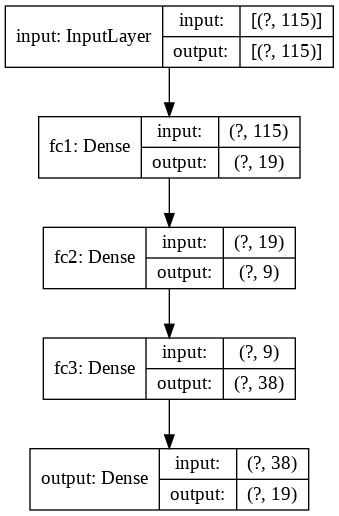

In [6]:
class DenseNN:

    def __init__(self, observation_shape: List[int], n_actions: int, 
                 output_activation: Union[None, str] = None,
                 unit_scale: int = 1, learning_rate: float = 0.0001, 
                 opt: str = 'Adam') -> None:
        """
        :param observation_shape: Tuple specifying input shape.
        :param n_actions: Int specifying number of outputs
        :param output_activation: Activation function for output. Eg. 
                                  None for value estimation (off-policy methods).
        :param unit_scale: Multiplier for all units in FC layers in network 
                           (not used here at the moment).
        :param opt: Keras optimiser to use. Should be string. 
                    This is to avoid storing TF/Keras objects here.
        :param learning_rate: Learning rate for optimiser.

        """
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.unit_scale = unit_scale
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.opt = opt

    def _model_architecture(self) -> Tuple[keras.layers.Layer, keras.layers.Layer]:
        
        frame_input = keras.layers.Input(name='input', shape=self.observation_shape)
        fc1 = keras.layers.Dense(int(self.observation_shape[0] / 1.5 * self.unit_scale), 
                                 name='fc1', activation='relu')(frame_input)
        fc2 = keras.layers.Dense(int(self.observation_shape[0] / 3 * self.unit_scale), 
                                 name='fc2', activation='relu')(fc1)
        fc3 = keras.layers.Dense(self.n_actions * 2, 
                                 name='fc3', activation='relu')(fc2)
        action_output = keras.layers.Dense(units=self.n_actions, name='output',
                                           activation=self.output_activation)(fc3)

        return frame_input, action_output

    def compile(self, model_name: str = 'model', 
                loss: Union[str, Callable] = 'mse') -> keras.Model:
        """
        Compile a copy of the model using the provided loss.

        :param model_name: Name of model
        :param loss: Model loss. Default 'mse'. Can be custom callable.
        """
        # Get optimiser
        if self.opt.lower() == 'adam':
            opt = keras.optimizers.Adam
        elif self.opt.lower() == 'rmsprop':
            opt = keras.optimizers.RMSprop
        else:
            raise ValueError(f"Invalid optimiser {self.opt}")

        state_input, action_output = self._model_architecture()
        model = keras.Model(inputs=[state_input], outputs=[action_output], 
                            name=model_name)
        model.compile(optimizer=opt(learning_rate=self.learning_rate), 
                      loss=loss)

        return model

    def plot(self, model_name: str = 'model') -> None:
        keras.utils.plot_model(self.compile(model_name), 
                               to_file=f"{model_name}.png", show_shapes=True)
        plt.show()


DenseNN(observation_shape=(115,), unit_scale=0.25, n_actions=19).plot()
Image(filename='model.png') 

#### Replay buffer [ リプレイバッファ] 
The replay buffer records previous state, actions, and rewards. [ 再生バッファは、以前の状態、アクション、および報酬を記録します。] When the agent is updated, it samples a batch from the replay buffer to create the training set. [ エージェントが更新されると、リプレイバッファからバッチをサンプリングして、トレーニングセットを作成します。] These samples can come from different episodes if the buffer is long enough. [ バッファーが十分に長い場合、これらのサンプルはさまざまなエピソードから取得できます。] This is necessary to reduce the correlation in the training data, which would be extremely high if, for example, the model was trained with just the last observation on each step. [ これは、トレーニングデータの相関を減らすために必要です。これは、たとえば、モデルが各ステップの最後の観測のみでトレーニングされた場合に非常に高くなります。] Neural networks don't do well with highly correlated training data. [ ニューラルネットワークは、相関性の高いトレーニングデータではうまく機能しません。]

In [7]:
@dataclass
class ContinuousBuffer:
    buffer_size: int = 50

    def __post_init__(self) -> None:
        self._state_queue = collections.deque(maxlen=self.buffer_size)
        self._other_queue = collections.deque(maxlen=self.buffer_size)

        self.queue = collections.deque(maxlen=self.buffer_size)

    def __len__(self) -> int:
        return self.n if (self.n > 0) else 0

    @property
    def full(self) -> bool:
        return len(self._state_queue) == self.buffer_size

    @property
    def n(self) -> int:
        return len(self._state_queue) - 1

    def append(self, items: Tuple[Any, int, float, bool]) -> None:
        """
        :param items: Tuple containing (s, a, r, d).
        """
        self._state_queue.append(items[0])
        self._other_queue.append(items[1::])

    def get_batch(self, idxs: Iterable[int]) -> Tuple[List[np.ndarray], 
                                                      List[np.ndarray],
                                                      List[float], 
                                                      List[bool], 
                                                      List[np.ndarray]]:
        ss = [self._state_queue[i] for i in idxs]
        ss_ = [self._state_queue[i + 1] for i in idxs]

        ard = [self._other_queue[i] for i in idxs]
        aa = [a for (a, _, _) in ard]
        rr = [r for (_, r, _) in ard]
        dd = [d for (_, _, d) in ard]

        return ss, aa, rr, dd, ss_

    def sample_batch(self, n: int) -> Tuple[List[np.ndarray], 
                                            List[np.ndarray],
                                            List[float], 
                                            List[bool], 
                                            List[np.ndarray]]:
        if n > self.n:
            raise ValueError

        idxs = np.random.randint(0, self.n, n)
        return self.get_batch(idxs)

#### Epsilon greedy [ イプシロングリーディ] 
Epsilon greedy is used to force the agent to explore the environment. [ イプシロングリーディは、エージェントに環境を探索させるために使用されます。] When the agent is asked for an action, it draws a random sample between 0-1. [ エージェントがアクションを要求されると、0から1の間でランダムなサンプルが抽出されます。] If this value is >epsilon, the agent simply selects a random action. [ この値が\u003e epsilonの場合、エージェントは単にランダムアクションを選択します。] Typically epsilon is set high at the beginning of training, and is slowly decayed over time. [ 通常、イプシロンはトレーニングの開始時に高く設定され、時間の経過とともにゆっくりと減衰します。] This class tracks it and handles the random action selection. [ このクラスはそれを追跡し、ランダムアクションの選択を処理します。]

In [8]:
@dataclass
class EpsilonGreedy:
    """
    Handles epsilon-greedy action selection, decay of epsilon during training.

    :param eps_initial: Initial epsilon value.
    :param decay: Decay rate in percent (should be positive to decay).
    :param decay_schedule: 'linear' or 'compound'.
    :param eps_min: The min value epsilon can fall to.
    :param state: Random state, used to pick between the greedy or random options.
    """
    eps_initial: float = 0.2
    decay: float = 0.0001
    decay_schedule: str = 'compound'
    eps_min: float = 0.01
    state = None
    
    def __post_init__(self) -> None:
        self._step: int = 0
        self.eps_current = self.eps_initial

        valid_decay = ('linear', 'compound')
        if self.decay_schedule.lower() not in valid_decay:
            raise ValueError(f"Invalid decay schedule {self.decay_schedule}. "
                             "Pick from {valid_decay}.")

        self._set_random_state()

    def _set_random_state(self) -> None:
        self._state = np.random.RandomState(self.state)

    def _linear_decay(self) -> float:
        return self.eps_current - self.decay

    def _compound_decay(self) -> float:
        return self.eps_current - self.eps_current * self.decay

    def _decay(self):
        new_eps = np.nan
        if self.decay_schedule.lower() == 'linear':
            new_eps = self._linear_decay()

        if self.decay_schedule.lower() == 'compound':
            new_eps = self._compound_decay()

        self._step += 1

        return max(self.eps_min, new_eps)

    def select(self, greedy_option: Callable, random_option: Callable,
               training: bool = False) -> Any:
        """
        Apply epsilon greedy selection.

        If training, decay epsilon, and return selected option. 
        If not training, just return greedy_option.

        Use of lambdas is to avoid unnecessarily picking between 
        two pre-computed options.

        :param greedy_option: Function to evaluate if random option 
                              is NOT picked.
        :param random_option: Function to evaluate if random option 
                              IS picked.
        :param training: Bool indicating if call is during training 
                         and to use epsilon greedy and decay.
        :return: Evaluated selected option.
        """
        if training:
            self.eps_current = self._decay()
            if self._state.random() < self.eps_current:
                return random_option()

        return greedy_option()

#### Agent [ エージェント] 
The agent estimates actions values from states, and learns from its experience. [ エージェントは状態からアクション値を推定し、その経験から学習します。] Most of the magic happens in the .update_model, where the problem is formulated into something that can be learned by the DenseNN model. [ 魔法のほとんどは.update_modelで発生し、問題はDenseNNモデルで学習できるものに定式化されます。]

In [9]:
@dataclass
class DeepQAgent:
    replay_buffer: ContinuousBuffer
    eps: EpsilonGreedy
    model_architecture: DenseNN
    name: str = 'DQNAgent'
    double: bool = False
    noisy: bool = False
    gamma: float = 0.99
    replay_buffer_samples: int = 75
    final_reward: Union[float, None] = None

    def __post_init__(self) -> None:
        self._build_model()

    def _build_model(self) -> None:
        """
        Prepare two of the same model.

        The action model is used to pick actions and the target model
        is used to predict value of Q(s', a). Action model
        weights are updated on every buffer sample + training step. 
        The target model is never directly trained, but it's
        weights are updated to match the action model at the end of 
        each episode.
        """
        self._action_model = self.model_architecture.compile(
            model_name='action_model', loss='mse')
        self._target_model = self.model_architecture.compile(
            model_name='target_model', loss='mse')

    def transform(self, s: np.ndarray) -> np.ndarray:
        """Check input shape, add Row dimension if required."""

        if len(s.shape) < len(self._action_model.input.shape):
            s = np.expand_dims(s, 0)

        return s

    def update_experience(self, s: np.ndarray, a: int, 
                          r: float, d: bool) -> None:
        """
        First the most recent step is added to the buffer.

        Note that s' isn't saved because there's no need. 
        It'll be added next step. s' for any s is always index + 1 in
        the buffer.
        """

        # Add s, a, r, d to experience buffer
        self.replay_buffer.append((s, a, r, d))

    def update_model(self) -> None:
        """
        Sample a batch from the replay buffer, calculate targets using 
        target model, and train action model.

        If the buffer is below its minimum size, no training is done.

        If the buffer has reached its minimum size, a training batch 
        from the replay buffer and the action model is updated.

        This update samples random (s, a, r, s') sets from the buffer 
        and calculates the discounted reward for each set.
        The value of the actions at states s and s' are predicted from 
        the value model. The action model is updated using these value 
        predictions as the targets. The value of performed action is 
        updated with the discounted reward (using its value prediction 
        at s'). ie. x=s, y=[action value 1, action value 2].
        """

        # If buffer isn't full, don't train
        if not self.replay_buffer.full:
            return

        # Else sample batch from buffer
        ss, aa, rr, dd, ss_ = self.replay_buffer.sample_batch(
            self.replay_buffer_samples)

        # Calculate estimated S,A values for current states and next states. 
        # These are stacked together first to avoid making two separate 
        # predict calls (which is slow on GPU).
        ss = np.array(ss)
        ss_ = np.array(ss_)
        y_now_and_future = self._target_model.predict_on_batch(np.vstack((ss, ss_)))
        # Separate again
        y_now = y_now_and_future[0:self.replay_buffer_samples]
        y_future = y_now_and_future[self.replay_buffer_samples::]

        # Update rewards where not done with y_future predictions
        dd_mask = np.array(dd, dtype=bool).squeeze()
        rr = np.array(rr, dtype=float).squeeze()

        # Gather max action indexes and update relevant actions in y
        if self.double:
            # If using double dqn select best actions using the action model, 
            # but the value of those action using the
            # target model (already have in y_future). 
            y_future_action_model = self._action_model.predict_on_batch(ss_)
            selected_actions = np.argmax(y_future_action_model[~dd_mask, :], 
                                         axis=1)
        else:
            # If normal dqn select targets using target model, 
            # and value of those from target model too
            selected_actions = np.argmax(y_future[~dd_mask, :], 
                                         axis=1)

        # Update reward values with estimated values (where not done) 
        # and final rewards (where done)
        rr[~dd_mask] += y_future[~dd_mask, selected_actions]
        if self.final_reward is not None:
            # If self.final_reward is set, set done cases to this value. 
            # Else leave as observed reward.
            rr[dd_mask] = self.final_reward
        aa = np.array(aa, dtype=int)
        np.put_along_axis(y_now, aa.reshape(-1, 1), rr.reshape(-1, 1), axis=1)

        # Fit model with updated y_now values
        self._action_model.train_on_batch(ss, y_now)

    def get_best_action(self, s: np.ndarray) -> np.ndarray:
        """
        Get best action(s) from model - the one with the highest predicted value.
        
        :param s: A single or multiple rows of state observations.
        :return: The selected action.
        """
        preds = self._action_model.predict(self.transform(s))

        return np.argmax(preds)

    def get_action(self, s: np.ndarray, training: bool = False) -> int:
        """
        Get an action using get_best_action or epsilon greedy.

        Epsilon decays every time a random action is chosen.

        :param s: The raw state observation.
        :param training: Bool to indicate whether or not to use this 
                         experience to update the model. If False, just
                         returns best action.
        :return: The selected action.
        """
        action = self.eps.select(greedy_option=lambda: self.get_best_action(s),
                                 random_option=lambda: self.env.action_space.sample(),
                                 training=training)

        return action

    def update_target_model(self) -> None:
        """
        Update the value model with the weights of the action model 
        (which is updated each step).

        The value model is updated less often to aid stability.
        """
        self._target_model.set_weights(self._action_model.get_weights())

    def after_episode_update(self) -> None:
        """Value model synced with action model at the end of each episode."""
        self.update_target_model()

    def _discounted_reward(self, reward: float, 
                           estimated_future_action_rewards: np.ndarray) -> float:
        """
        Use this to define the discounted reward for unfinished episodes, 
        default is 1 step TD.
        """
        return reward + self.gamma * np.max(estimated_future_action_rewards)

    def _get_reward(self, reward: float, 
                    estimated_future_action_rewards: np.ndarray, 
                    done: bool) -> float:
        """
        Calculate discounted reward for a single step.

        :param reward: Last real reward.
        :param estimated_future_action_rewards: Estimated future values 
                                                of actions taken on next step.
        :param done: Flag indicating if this is the last step on an episode.
        :return: Reward.
        """

        if done:
            # If done, reward is just this step. Can finish because agent has won or lost.
            return self._final_reward(reward)
        else:
            # Otherwise, it's the reward plus the predicted max value of next action
            return self._discounted_reward(reward, 
                                           estimated_future_action_rewards)

#### Play single episode [ 単一のエピソードを再生する] 
An episode refers to one play through an enviroment. [ エピソードとは、環境を介した1回のプレイを指します。] It will take many episodes to train an agent [ エージェントを訓練するには多くのエピソードが必要です]

In [10]:
def play_episode(env: gym.Env, agent, n_steps: int=10, pr: bool=False, 
                 training:bool=False) -> Tuple[List[float], List[int]]:
    
    episode_rewards = []
    episode_actions = []
    
    obs = env.reset()
    done = False
    for s in range(n_steps):
        if done:
            break

        # Select action
        action = agent.get_action(obs)
        episode_actions.append(action)

        # Take action
        prev_obs = obs
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)

        # Update model
        if training:
            agent.update_experience(s=prev_obs, a=action, 
                                    r=reward, d=done)
            agent.update_model()

        if pr:
            print(f"Step {s}: Action taken {action}, " 
                  f"reward recieved {reward}")

        last_step = s
    
    if training:
        agent.after_episode_update()
                  
    return episode_rewards, episode_actions
                  

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
agent = DeepQAgent(
    # Realistically this should be more like 100,000!
    replay_buffer=ContinuousBuffer(buffer_size=1000),  
    eps=EpsilonGreedy(),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               # This is also set too low to make running in a notebook easier
                               unit_scale=0.25,
                               n_actions=env.action_space.n))

_ = play_episode(env, agent, n_steps=20, pr=True, training=True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Step 0: Action taken 10, reward recieved 0.0
Step 1: Action taken 5, reward recieved 0.0
Step 2: Action taken 5, reward recieved 0.0
Step 3: Action taken 5, reward recieved 0.0
Step 4: Action taken 10, reward recieved 0.0
Step 5: Action taken 18, reward recieved 0.0
Step 6: Action taken 18, reward recieved 0.0
Step 7: Action taken 18, reward recieved 0.0
Step 8: Action taken 18, reward recieved 0.0
Step 9: Action taken 18, reward recieved 0.0
Step 10: Action taken 2, reward recieved 0.0
Step 11: Action taken 5, reward recieved 0.0
Step 12: Action taken 5, reward recieved 0.0
Step 13: Action taken 1, reward recieved 0.0
Step 14: Action taken 3, reward recieved 0.0
Step 15: Action taken 3, reward recieved 0.0
Step 16: Action taken 3, reward recieved 0.0
Step 17: Action taken 3, reward recieved 0.0
Step 18: Action taken 3, reward recieved 0.0
Step 19: Action taken 3, reward recieved 0.0


#### Play multiple episodes [ 複数のエピソードを再生する]

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 0 finished after 3000 steps, total reward: -1.0
Episode 1 finished after 3000 steps, total reward: -8.0
Episode 2 finished after 3000 steps, total reward: -6.0
Episode 3 finished after 3000 steps, total reward: -3.0
Episode 4 finished after 3000 steps, total reward: -8.0
Episode 5 finished after 3000 steps, total reward: -5.0
Episode 6 finished after 3000 steps, total reward: -6.0
Episode 7 finished after 3000 steps, total reward: -3.0
Episode 8 finished after 3000 steps, total reward: -3.0
Episode 9 finished after 3000 steps, total reward: -4.0


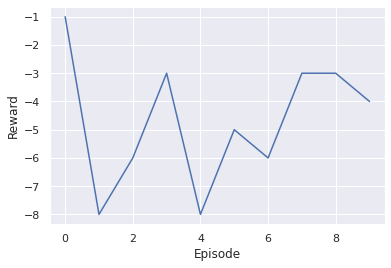

In [11]:
def run_multiple_episodes(env: gym.Env, agent, n_episodes: int=10, 
                          n_steps: int=10, pr: bool=False, 
                          training:bool=False) -> List[float]:

    
    total_episode_rewards = []
    for ep in range(n_episodes):

        episode_rewards, _ = play_episode(env, agent, n_steps, 
                                          pr=False, training=True)

        total_episode_rewards.append(sum(episode_rewards))
        
        if pr:
            print(f"Episode {ep} finished after {len(episode_rewards)} "
                  f"steps, total reward: {sum(episode_rewards)}")

    
    return total_episode_rewards


env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
agent = DeepQAgent(
    replay_buffer=ContinuousBuffer(buffer_size=1000),
    eps=EpsilonGreedy(eps_initial=0.7),
    model_architecture=DenseNN(observation_shape=env.observation_space.shape, 
                               unit_scale=0.25,
                               n_actions=env.action_space.n))

# Both n_episodes and n_steps need to 
reward_history = run_multiple_episodes(env, agent, n_episodes=10, 
                                       # Use 3000 for 90 minute games
                                       n_steps=3000,  
                                       training=True, pr=True)

plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

#### Compare to a random agent [ ランダムエージェントと比較する] 

In [12]:
class RandomModel:
    def __init__(self, n_actions: int):
        self.n_actions = n_actions

    def predict(self) -> int:
        return int(np.random.randint(0, self.n_actions, 1))


@dataclass
class RandomAgent:
    """A random agent that acts randomly and learns nothing."""
    n_actions: int
    name: str = 'RandomAgent'

    def __post_init__(self) -> None:
        self._build_model()

    def _build_model(self) -> None:
        """Set model function."""
        self.model = RandomModel(self.n_actions)

    def update_model(self, *args, **kwargs) -> None:
        """No model to update."""
        pass

    def get_action(self, s: Any, **kwargs) -> int:
        return self.model.predict()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


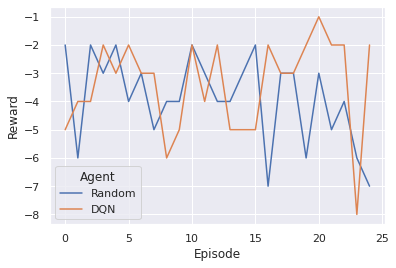

In [22]:
env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0")
obs = env.reset()

random_agent = RandomAgent(n_actions=env.action_space.n)

ra_reward_history = run_multiple_episodes(env, agent, n_episodes=25, 
                                          n_steps=3000, training=False)
dqn_reward_history = run_multiple_episodes(env, agent, n_episodes=25, 
                                           n_steps=3000, training=False)

plt.plot(ra_reward_history, label='Random')
plt.plot(dqn_reward_history, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(title='Agent')
plt.show()

#### Prepare submission [ 提出の準備] 
This is covered in a bit more detail in the next notebook: https://www.kaggle.com/garethjns/convolutional-deep-q-learner . [ これについては、次のノートブックでもう少し詳しく説明します：https：//www.kaggle.com/garethjns/convolutional-deep-q-learner。] In short, we need to create a single file containing the agent components we need for inference, including the serialsed model weights. [ つまり、シリアル化されたモデルの重みなど、推論に必要なエージェントコンポーネントを含む単一のファイルを作成する必要があります。] We also need to add to agent function that acts given an environment observation. [ また、環境観察を前提として機能するエージェント機能を追加する必要があります。]

#### Get model weights [ モデルの重みを取得する]

In [23]:
import zlib
import pickle
weights_bytes = zlib.compress(pickle.dumps(agent._action_model.get_weights()))

In [24]:
weights_bytes

b'x\x9c=\xbay<\x97\xdf\xf3>n\xdfS\xa2,QvI\x0bB\xc5=\xa3\x94R"\x15J\xa8P\xb4*\x12\xed\x89\xec\x92D\x94B(I"\x92x\xde3\xdaK\xab\xf6MI\xa5U\xfb^\xaa_\xaf\xf7\xf7\xf7\xf8\xdc\x7f\x9c?\xee\xfb\x9c\x99y\x9c{\xce5\xd7u\x1e\x13+\x1b\x18!\xd5?$|\xf9\xe2\xa5+\x07\x87,\x89\x9c;x\xf1\xf2EQ\xf3\x83"#\x83V\xaa\xcc\x8a\x9c\x1b\xb2$|YT\xe4\xf2\x90(\x95\x08\xe9\xff7K%|\xce\xff\xfb\x1a!\xe3.\x95\x10!;Z:8B.)B~J\x84B\x7fwi\xf7e\xee\x9a\x89\x11\x8a\xff\xff\xd49Q+\x97\xceU\x89P\x9a.#%%\x15j\x17\xa1\xec.\xe5.\x9d\x14\xa12%B\xb5\xbf\xbb\xect\xe9\x7fo\x85\x085OO\xcf\t\x7f\xff=\xff\x1b\xdc\xa5\xa2"\xba\x05\xa7\xb8\x98\x1aKI9\xbe\x99\x89\x9b%\xdf\xe8\x9d\xfd^\xa1\x8f}\x00O\xac\xa8\x80\xae@m\xa8X\xad\xc1O\x06\xf5\xc1\x1d\xb1\x91B\xec\xa0Y\x8d\x13\xe5\x7fP}\xc2T\xca\xd8\xe5\x0b\xb5\xd6\x0f\xa8\x12G\xf2m\x97\xa1\x9c\xb0[\x0e\r?\xe9c\xb5\xb7\x12\xa6=w\x83\xc3\xb9\xb3po\xd1zZ\xd5}\x06k\xfb\x1c\x06\xd9\t\xa6\x18X\xf6\x84\xee\xf6\xeb/N\x99\\\x0f#\xae\xdb\x83\xd7\xad:T]\x9e\x8f\xd6\x97\xce\xc1\xb5\xf1\x850~\xfaCN\xd9\xf9

#### Create submission.py [ submit.pyを作成します] 
Copy and paste the contents of weight_bytes into WEIGHTS_BYTES [ weight_bytesの内容をコピーしてWEIGHTS_BYTESに貼り付けます]

In [27]:
%%writefile submission.py

import zlib
import pickle
import tensorflow as tf

import numpy as np

from tensorflow import keras
from typing import List, Tuple, Union, Callable
from gfootball.env.wrappers import Simple115StateWrapper

WEIGHTS_BYTES = b'x\x9c=\xbay<\x97\xdf\xf3>n\xdfS\xa2,QvI\x0bB\xc5=\xa3\x94R"\x15J\xa8P\xb4*\x12\xed\x89\xec\x92D\x94B(I"\x92x\xde3\xdaK\xab\xf6MI\xa5U\xfb^\xaa_\xaf\xf7\xf7\xf7\xf8\xdc\x7f\x9c?\xee\xfb\x9c\x99y\x9c{\xce5\xd7u\x1e\x13+\x1b\x18!\xd5?$|\xf9\xe2\xa5+\x07\x87,\x89\x9c;x\xf1\xf2EQ\xf3\x83"#\x83V\xaa\xcc\x8a\x9c\x1b\xb2$|YT\xe4\xf2\x90(\x95\x08\xe9\xff7K%|\xce\xff\xfb\x1a!\xe3.\x95\x10!;Z:8B.)B~J\x84B\x7fwi\xf7e\xee\x9a\x89\x11\x8a\xff\xff\xd49Q+\x97\xceU\x89P\x9a.#%%\x15j\x17\xa1\xec.\xe5.\x9d\x14\xa12%B\xb5\xbf\xbb\xect\xe9\x7fo\x85\x085OO\xcf\t\x7f\xff=\xff\x1b\xdc\xa5\xa2"\xba\x05\xa7\xb8\x98\x1aKI9\xbe\x99\x89\x9b%\xdf\xe8\x9d\xfd^\xa1\x8f}\x00O\xac\xa8\x80\xae@m\xa8X\xad\xc1O\x06\xf5\xc1\x1d\xb1\x91B\xec\xa0Y\x8d\x13\xe5\x7fP}\xc2T\xca\xd8\xe5\x0b\xb5\xd6\x0f\xa8\x12G\xf2m\x97\xa1\x9c\xb0[\x0e\r?\xe9c\xb5\xb7\x12\xa6=w\x83\xc3\xb9\xb3po\xd1zZ\xd5}\x06k\xfb\x1c\x06\xd9\t\xa6\x18X\xf6\x84\xee\xf6\xeb/N\x99\\\x0f#\xae\xdb\x83\xd7\xad:T]\x9e\x8f\xd6\x97\xce\xc1\xb5\xf1\x850~\xfaCN\xd9\xf9\x94\x0e\xe93\x9d\xccS\xc5\xa0~\xf2x\xac\xcf\x0e\xf1\xce\xcbgB\xde\x9b\xbd4\xe6\x837v\xdf\xa3&)Y\xf3\n^\x04\x17\xd0\xcb\x1d\x85P\xf8c,\xce\xde\x11\x88\x9f\xf4^\x11}2\xc5\x9a@\x81n\xcd\xa9\xa6`\xd3\x89\xb0\xd8^\x1b\x9f\x1cu\xe4\x0f\xb7\x92hf\xf1|H\xbb4\x0c7d\xf7\x85\x8a\xd2\x00\xeaZn\xcbgK\x0b\x85\x9aQK\xe8B\x80.\x1e\x98\xa3\x8b\xeb+\xb6\xf23\xc7C0;v3\xa9*\x02h\xc4\x8e\x86\xfe\x13Ki\x80\x9d\x13\x7f\xdb\x98\x0f7\xbb\xceBlf5\xd8\xb9W\xe0\x88*c\xbc\xdf\xd1\x0b\xff\x1a\x97\x88\xe7l\x02\x04ty\x022\x1fc\xe8\x9d\xa5\xbcpg\xad\x15,9j\xc6\x0b#\x8f\t\xf7\x9ef:\xd9\x85\xda\xf18\x1b\x05\xecn7\x90\xbb;[\xc2\xac\xe9\xe9tK\xe9\x11<\xb9\x1e\x8e7\xac\\x\xc9\x12EL\xf3\x0b\xa1\xef:z0\xe1\x89;\xd3\xba\xbdB\xeb\xd4O\xf4\xfa\x8b;-\xa3\x9e\xac\xb2\xea<\xf4\xd1\x98\x0es\x7f\x0e\x85\xe6\xf6\x03\xf4\xebE1\xd9kUPk\xf1\x1b\x1a\x13>\x84\xe7v5\xa1\xf2\xf9\x06r\xad\xcc\x07\xdf\xca\xd3\xd4\xdb\xd6\x01\xbd\xce\xd8\xb0Y\xc6n\xf1\x96mo\x1e\xb4\xb9\x9c\xde\xbf\xb5\xe5\x17\xdb4x\xb0\xf99*\xa8\xb1\xc0\xb8;\xc9B\x92\xa3\x05\xea.W\xe1\'\x01C\xd9\xbcWo\xcc\xd0\xce\xa6-\xfe\xba\xfc\xdd\xe26\xa5\x84\xf7\x94t\x15\xab\xf3\xf7\x9b\xcf\xe9q\xea~\xa8T\xcd\xe3\xf7\x05\xba<\xed\xe8\x04\xb1\xba*\x95\x8a\'x\x88a\xd7\x16\xe0\xf5\xdc^|yc\x8c\x905]\x11\xcf_\x95\xe3G\x9f\xcb\xc9\xa2 \x08#6\xcc\xa1]\x95\x19\xa01[\x15\xf4<\xf6\xe1\xdb\x8e6\x92^YC\x18\xe9\xc6g/f\xd0\xae\x9dj\xb8e\xa49/qq\xe5\xf4\xb8\x9b \xd7)\xc7a\x7f\xaeB\xf0\xeb\xbf\xf0\xe9\xc8C:q\xe3\xa3\xf0\xf9c(\xc8\xe8\x1a\xe1\xef\xb0?\xe2\x8b\x113\xb8&\xe4\x1b\xcd\x90\xf2\'\xdd\xd6g\x90\xfd@\x17uR\xbb\xc00\xc5\x18\'6\xce\x82p\xc7\xb9\xd0;A\x1e\xc7JI\xa1Jv/\xb4\x1ct\x96\x1c\xa4\x13\xb1\xfe\xcc\x18\x881\n\x05\xd7\x9e\x0e|\xcf\xb3\x96\x12\x83\xd4\xc8\xdeQ\x89\x8d\x8e\xc9\xe2wj#\rk#\x9e\x93\'\xcd\xef;-!w\xa2\x13\x0c?Z$\xbc\x7f\x11G\x1f:L(\xe9\xa6!\x06/L\'\xbd\xd2\xb7\xb4mn\x11U\xa7O\x13b\x12\xcd\xf8\xc9\x8b8\xb8\xa35\x18w.P\xe7\xdb%\xba\xac\x1a\xa6\x8c\xdd\xcb\xc7\xf0\x8d]S\xd1Y&\x9b\x06\x06W\xd0\xda\xc5sy\x8a\x9d\x16\xbc2\x1d\x89\xa9\x83z\x90\xe3\xc3\x0cJ~\xfc\x16\xac\xef\xd8\xf3\x83o\x8a8h\xdckA\xcd\xcc\x9a\x07\xcf9*F~\x19\xc9\'\x7f-\xe0\xf3J*\xec$\xaf\xc2+/(\xa1\xef\xb5\x83\xf0\xf1\x90\x11\xa6\xa8\xdf\x87\x1eW\x05\x1e\xe2>\x03\x85^\xc5N\x89\xd3u\xc4\x95S\xd7\x88\x19#\xd2\xe1\xba\xdbO:\x99V\x03^\xda\x1a\xdc*\xfb\x0c~\xf6j\x02\xe7\\)\xf4\x9fj\xca!\xdf\ra\xcd\xe9TZ\xe9e\x8bc\x0ema\xe7\xaf\x0b\xa1}\xb9\t\x06\x16=\x85C\xcf]\xe9\xdd+g\\\xfdf4n\xe8\xbd\x98\xaf\xd5m\xe0\x95\xb7o\xc3\xcbIC\xb0\xcb\xe6\x1b\x9d\xab\xd6\xe1L\xf9/B\x8c\xcdJ\\4V\xd51\xd9\xa7\x18\xae\xbfO\xe6\xd7\x11[)hr_\xdc4\x13\xf0U\x8f\xc1\\\xd1\xa4\x89\xee\xf1*x\xbb\xfa\x06<\xf8z\x13\xbc\x14m9\xc3\xb7\x0f\xcb\xf9\x8c\xc1\xd8+\x8b\xa9\xe0\xa2\x16\xf6_ \x87_GXS\xc1\xe7\x93d!}X\xbc~\xc1\x10\xfc\xa5\xd4h\xed\xbbRH\x95t:\xf5)\x89\xc4S\x87[\x04\x85_\x12\xf1\xe0\xae\xbf4\xc1s\x16\xbf\xbad\xcf\xbf\xb2\x89f5\xf5"\x83\x9czz\xd1\xeb\x808*\xf8\x1b\xac8\xb0\x94\xbf\xa7\xbf\x10-\xce\x97\x93\x81n9\xbd{\xa2\x87\x14\x91A\x0e\x853\xe1b\xd6Y\xa1"<\x8edo\xad\xa0>#2\x85\xe3\xcd/\xe1\x8b\xfd<x:b\x12\xa8X\xc9\x90\xbe\x1d\x82\xc1\x88\xb3\xb4x\x9f\x15\x9e\xf6\x8de\xbfTM\x9e\xbb{,\x07\xb5\xf6\xe0\xf3s\x06\n\xd9\xeb6\xd1\xdde\xee\xd0\xb2\xa6U,\xbf\xfaE\xb0I\xe9\x86\x9dz}\x00\x0f\xfd\x11\x7f?\xdfL;w\x9b\x88C^O\xa2\xa1\x99\x939\xc2\xa6\x83\xcex\xdf\x12{\xbe\xd8%\x86\xdf\x92\xe5\xe3\x7f\xe7\xe1\xb0\tk\xe1\xb5\xb7\x0eu\x0c\x08CKW%>\xf8[\x87\xcf\xdf\x8b\x16WY\x87\x92L\xe0\x0c\x96\xfbc\x02\xb6G\x10X=\x84\x82\x142\xa9\xc9s(\xafp\x8a\xe5pi\x7f8y\xa47N-3\xe6\x9d\xed\xa1\xe2\xb4\xe4\x1c*0\x1cH6\xda~\x10n\xf1\xcd\xa9vO\x05]\xd6w\xa0\xf7K\xa4\xd1\xb9\xdb\x00\xee\xa68\x8eC{\xdbrvi\xa8\xd3\xe2\xe6tr\xea;\x9a\xce\xccR\xa5\xdd%\xf3\x1c\xbf\x7f\xad\x84\xab\xddO\x90e\x9f\xe9,;\\\x1f\xe7\xbe\xf1\x82[M\xba\x988\xdc\x1f\xf4\xd6\xdab\x89\xad4\xd6\x85\xf4\xc2\xb6B\t\xbc\xf3\xf8F\xc7/\xccb\xf7\x9b\xaf\t\xcc4pX\xb85\xaa?-\xa7\xefd\xcb\xab;\x0e\xc1\xa15\x9bD\x87?sQ\xabH\x8b\xe5\x12_\xd1"\x9fK\x90\x06\x0e\xf8""\x14CF\xcd\xa1\xe8\xdf\xb7!\xd0\xd6V\xa8\xb7\xec\x87\x91\xcf\x95\xe9J{\x1b\xed>\xf0\x934\xdb\xa4\x85\x99\x9b*\xc5\xc1\xc9\xad0\xe9e!\xcc\x9f\xb6W<\xe1\x11\xcc\xb2\x01\x1d\xb4\xe2\xd9\x0f\x98\xa6\'\xcf_\x13{\xe0\x93\xda\xfe<[;\x0f\xe0\xc7mq\xca\xb5\x10\x08u*\x07M\xc5>\xf8Y\xa6\x8b\xa77\r%\x17\x9d>\xecs\xfb$z\x9d\xd4\xc1Y\xbf\xfa5Y\xc5$b\xe8\xd8\xe9\xf8t\xf4n\xbacV \x04\xda\xa9\xe3\x89\x95\xeb8\xcce0\x9f\xf6\x95\xa0\xa0l\x86\xa9\xc3T\xe0\xfb\xb0"\xac\xbf\xe7\x8e\xee\xda\xa2\x186D\x0b\x1d\x87\x94\xc3\x97-#xq\x8d4\xa5T\xdb\x82\xcc\x06\x03x3@\x83\x95_\x1d\x82\x13*jl\xf4\xf2\x11d\x9eX\x07~A\xf7h\xf2\xf1\x06\x89\x83\xb7\x1b\xec\x8e\xb6\xe7[\x11\xa7\xb9\xfc\xc7T\xd1\xe2y\x0eL\x8b\xdbLM\xf3\x7f\xd0\x8d\xe5\x0b\xd8V\xe2\xc5\x8d\xa6w\x85\xd8\xbd+Q\xa3)\x18\xadd2\xd0 {\x0fE\x98\x99\xf1\xd4\xef\x07\xc5\xe0\x9c\x05|Gq3\xa9\x7f\x1e\xc6\xbb\xcbd\xa9a\xd3\x03\n=\xf5\x0e\xad2\xc7c\xf0\xb9\xcd,\xf4\x0f\xc3\xd6q\x89\xbc\xfa\xc1P\xbc`\xd6 \\Z\xbd\x00\x95\xded\xc1\xdb\xbc`\xf4\x1f3\x1e\x97\xac\x8f\x86\xf1\xe7&\xe3\xf4\x84~\x18\xcdC\xf9^\xd7R\xae\xd1\x19\xc0\x1b\x0b\xcaa\xebvw\niZ\x87\x06Y\xfd\xd9\xaa4\x1e\x8d\xa2\x151\xe3\xc7>\xaev-\x16\x12^&\xc1\xb7\x8d\xdb\xc4\x9dN\xe1\xb8;=\x10\x8f\xd9\xff\x85T\xac\xa3)\x9f\xd4Y}\x9f@\t\xfb*aV\xb8>\x87\x95V\xc3\xa4\xad\xe6\x12\xb7\x9b2\x1c$WDk^\xdc\x84\xbeGd\x9a\xe2-L\xa0\\\xc8\xe2\xb7\x1a\xfb%}\x97\xfc\x96\xd8\xad-\xa7\x97\xb37\xd039E\xee\xbb \x0c\xa5U\xfdx\xfc\xcf\x12\xb8\x1f\xadGcN\x0e\xe5\xac\xd7\x9e\xfcgf\x02\x1d\xd8\xa3+\xec\xbd\xaf\x81A\xd1\x85hro\x03\xaf\xfbT@\x89\r\x08\x1av\x89\xe0\xbbP\x1d\x9d\xabN\xd0\x99\xdb}\xa9U/\x0f\xc6\xefI\x87\xd6}/y\xc2\xccB\x08\x7f\xc0t#\xc2\n\xc7\xe9)\xa2\xd1\x94l\x1c\\\x16"\xea\xfcZ\xcb\xc3|\xef\xc3\xae\x1bQ\xec\xfa\xf04,\xb7I\xa4\xe6o\xa1\xc2\xda\x02+\x0e;s^\x12k\xdc\xc8\xdfL\x9e\tu/7b\xdbC\x1d\x86\xeb:x\xae\x8f%v\xc6\x19q\xa5\x8e\x84\xc6\x0e{\x06\x9be\x12\xf0]\xb2>\x17\xf8\'\xc3\xc3s\xda8q\xae%\xe8\x85\xe7\xb1k\xefX\xb0\xdb\xb5\x17\xb4\xbdG`\x11KaY\x83%\xbe\x8e\x08\xa2~\xc7\x07a\x8f\xbb\xc5\\%\xbb\x9df\xddx"\xa8\xf5\x03\x1aW\xbc\x9c\xbc\xf4\x04\xce\xf3\xd8\x80\x89\xd7|)6\xd0NhR\xf1\x14\xcf\xcb\xf5\xe6\x1eG7\xd1\x8d=\xc9\xa2\xc5\xa9^\xfc|L,\xafo/\xe1\xa5\xd6\xf3\x80\xae\xec\x15\x8dj_A\xeb\x9e8R\x0b\x95\xc3\xfd\xc1\xe3i\xfef\x1b6\xd4s\x03\x97\xba-\xff\xf6m\x83\xd8\xa4g\xc6\x136f\x80\x85\xc6x\x90]5\n\xdb\xbb\x96\xe3W\xa7vh\xe9U!\x04U\xf8K\xf4oFs\xed\x17\xe0(\xad\xe5\x18R1\x16\'m<\x06\xab\x96\x7f\x80\'\xb3\xe3\xb1\xa6\xed:{\xfe*\xa1\x9f\xa1n0"c\x16\xde\x1b[)\xfe\xcd\x92\xc3\rEo\xc0\xfa\xc37\xba\xb9\xba\x04|\xfeV\xb2^_\r\xd4\x08\xef\x82\xb4\x17\xd3\xf9\xf5:g\xfad\x7fFP\xb3\xd7\xe1\x9f\x0b<Q\xf6y=,\t\xef\x85\x07M\x06\xd0\xc0\xeb\xf2x\xe5\xa7?\xfa\x1an\x82\xa7\x1b\xad\xc85\xaa\x8b\xac\xae_\x87k7\xaf@M_\x86\x98\x12\r<\x16\xbd\x05=\x03R!kY3(\xbf:\x03n\xa7\x92\xf0\x89Q\x14\xae\x1c\xbb\x9e\xd5\xbdz\xf2E\x07k\x9ea\xa4\xd0\x94\xd9\xf0\x03z\xb8L\xa6\xc9\xc1)\x18\x97\x11\xe9t\xeb\xa4\x1f\xaa\xb6\x98c\xb0z\x0e\xadrY\x8c\x16\x83\xba\xb1\xa2\xc3B\xa8>UBm\x9f\xb4\x98z\x14\xd1;\xadZ\xb0\xe8\x1bK\x8eUM\xc2\xcd\x9c\x0c\xbc\xea\xf6\x1cJ\xf6\xad\xc5s?\xabhU\x90>z\x17\xc4\x93\x8dN+IU\x9b\xf2\xfa\xbd\xbaxl\xfbq,\x8e\x97\x85\x94\xd9\xc6\xa8\xb4i"\xf7\xf2:N\xa7\xc7\xbfD\xa1\xe5\x08\x17\x15k\xf3\xf1\xb0\x89\xd8\xa2\xde\x97\xde\x16\xe4\xe0\x9edMLL\x0b\xc27%\xe5\xe4\x1e\xdb\x87Vm\xf8\x00\x9e\xe9\xe7\x05W\xf8\x04\xb2\xc7\xc6q\x8b\x81=v\x96\xa6p\xc4\xa1\x9f\xe2\xa6U-\xa4apN\xf8<m\'~\x0b\xea\x87E%\xc3\xe9rf8\x1d\\\xd3\x0f\xa5\xd6\x19A\xafs[\xe0\xd7gw\x1cy\xe7\x13\xb9M=Jf\xb5\xbb\xa9\xf7\x90Rz\\\xe6\x88K\x06J\x0bSm\xdePT\xae\x1f\xc7\xea\xfc\xa1\x88\xadO\xc8\xd2t5\xe4_\xdf\xcb*!\xb1\x1c0\xd8\x03sWW\x91^\x8a\x8e\xa8\xe73\x89\xb4,\xe5\xf9\xe4\xa9\x89\\\xd9g$N\xe8\x0c\xe0\x86\xcf\xd68R^\x9f\xf7\xceh\x81t\xeb\x9d\xa8\xb0\xfa\xbc\x90\xbdp\x1b\xf4\xab\xd8\xe64w\xe02\xda?\xca\x06\xaa\x134\x98\x95\xeb\x1a\x9f>\xca\x175w\xbe\x84\x19\xe3-\xb0\x8f\xe4\xb9\xd0\xd6o\x02\x8a\x83\xca\xc4\xbc\x91\n\x1cc\xbd\x89\xfc\x8e\xb6Su\xdeU\x88?\x9d!\xee\xac\xf7@\x9a7\x1a\xb2\xd7\x9d\x84C)\xf2\xe8]*\xc7O\xac\x1b(\xff^\xae\xe4\\s\x7f.8\xb1W(\xe8\x91H\xab\x9af\x93c\xfd\x07\xfa0\xcf\x8b\xab\x85a\x1c\x96q\x02\xcaf\x97AWG5\xde}\xe6\x8f\x93\x86\xcd\x83Z\xfd\xad\xc2\xdc\xb2\xf1\x1c43\xc3\xe9\x98F1/-\xfbL]\xab/8\x95\x7f\xdf\x0b\xfb\x9b\xf4\xa0\xd6\xd2\x1emf\x1d\x87\x91\xd1#\xf9\xc2\xd3P\xd4\x89\xf6\xe6y\x8d\x12\xd1?\xc5\x88\x83g$\x81a\xf4(\xd4X\xdc\x9f\xa3\xe2\x8f\xc3|\xb9\x89\xfc@\xb6\x08w\x0c\xd4\x84e\xaf\xea\xc4S\xc7\x8f\xd3\x98\xcaVXU\xee\x02K\xd7\xe8\xd0\xcc\r.\xc2\x13\xa7<\xf8X\xb4\x81\xad\x9d7\xb0\xf3\xd8X\xe1\x89\xbb/kx^\xa7\xdd\xa7\xd7s\xc1\xd2L\xf4\xbb\x10L\x9a\x96\nX\x93\xfb@8\\\xfd\x8c\xd6\xbd\xcc\xa7\x11>{x\xa0R\xacpF\xf7*-\xbc\xa3\xcec\x0f\x8d\xc6#\x8f\x0cXP\xf5\xa5\xe4\xd9\xaf\xe8\x96V?\xb6W\xdaMq\x1a\x0bx\xe5\xf28\x18\xa6q\x91^\xd5\x16\xe1\xf3\x8e\xe9\xf4\xba\x9b\x1b\xab\xf7C!\xc0\xba\x81\xdd&m\xc6\x1d\x13"!J\x92@\x1a\x13j\xc4\xc2\xed#\xb1\xceN\x14\x1b\x83\'\xe2\x95}\xaa\xbc\xec\xb6\x99h\x1f\x1cK\x07\xe4\xb4\xb0d\xd5{\xf8\xe9<\x93\x9cF]\xa0\r\x1f\xfbp\xb6\xc10\xfc{%\x14\x93\xfc"\xa1J\xbf\x01\xf4\xb4ZH%\xf5\x13\xf59\xf5\x99Z\xa6\xb8b\xef\xca\x1bpv\xc16\\p\xd1\x84=w\xb9\xe2\x8d\xd3\xfe|\xf7U\x07}\xf1H\xa3\
xd1\xc6\x12zT=\x1b\xab\xc5\xb7\x92\xdd\xe7/\xc0\x96\xb3C\xe9\xc3\xef\x93\xf0a\xa6%\xab\xb7g\xf2\xad\xa6\x99P\xb5m#W]\xf3\xc6\xe7\xef\x03Y;c&\xbb\xdc\x19\xcdg\xb2N\xd2\x82\'Gab_/\xdc\x9bd\xc7\xcb\xe6|\x11\xdc\xcf\xdc\x13\xe2\xfd}h\xc5\xe4\x8d\xd0\xe3\xf0\x1f\xc9\xa8\xf6Q`U\x19\x88wv\x01\xdf|\x16O\xa9u\xe9x\xf1\xb9\x1b\x9f\xbb\x9d#D\xe69\x93\xeb-S\x9e6\xdf\x1c\xa7-{K\x13*\x12\xc8{f\x89(\xd3W\x06\x13&\xf8\xe3\x18\xa5a\\\x199\x87\xb2\x0b\x1f\x88J\x9d>x\xff\x801\x8d\xcc\xed\xcf\xe3G> ;;\xe0\x80\xd5\xa7h@^=\xadUU\xc4\x08\x89\x03\t*\x8bE\xe5\xd5\x87\xa0xZ\x81\xc4.!\x90\xff\x96\x19\xc3\xd7k=1\xe1\xc4J\xcc\x891\x96\xd8;\x0e\xc5KZ\x13\xe0\xcd\x8f\xf3\x10\xbd\xed>\x9d44A\xef.}^\xe7\xfa\x81\xfe(\x0c"\xbf\xb2\xd7\xe0\x14W\x05\xa6\xb2\xf6\x1c4{0\xfe\x91\xf2\xe4\xce\xde3\xe9H\xeeO\xd1\xba`\x03\'\x98\xc4\xc3\x8d}\xf7\xe8p{.\xb5\xb8\x94\xd2\xd1\xb4i\xfc\xaa\xb0\x0c6\xbc(u\xaat\x8c\'_\x8b\xd9\xdc\xf8\xa9\x82\xb4\x86\x9f\x84\x96\xc7"\xd9\xc6\xb7\x01\x1b.\xe7\xcaw\xf6\x92{\xf3]Q\\\x90/\x0e_\xbbR\xd0\x9eXF\xeb[\x99\xec[\xfb\xa0_\xcb,x\xbb\xc3\x12_\xdd}J\xd2\xb9\xdb`]\xb4+^\x98m\x8dS\xac\xdb\xa0\xe1z\x1aEm=Hj\xe6\x13\xc5k\xb9\xb1\xd4o\x8f?\xcb,\xd1\x13_\xcb^\x157n\x99\x01Zi\x91\x98\xe4/\xc7\xf3\xc6\xce\xc6\xafO\xd2%\xee2\x93\xe8\xf5\x82x\xccVX+\xfa\xa8t\xe3\xab\xf9A\xa8\xfa%\x15_h\xee\x04\xbb\x9b\xed\x14CypD\xf594\xc8\xef\x16\r\x8d=h\xb0g\x0b\x84\xbf\x89\xc0\xc6\xac\xfd4j$\xe0\xe0o\xdeBDH!y\x9f\xea\x14z\xcez@7}\xfc\xe0\xfc\xfd\x17\x90\xb2\xb4/\xe7{*C]\xaf\xfb\x14\x1d\xfd\x8f\x07\xd9\xfa\xc0i\xe5:Xd2\x84\xdf\x8d4\xe3ga\x19\xacb6\x9f\xe2\xba\xee\x80G\xeb/\xf8\xb9\xd9\x04\xf5o\x98\xf0\xbd\x83\xc3y\xee\xe7\t\xd45\xaa\x00\xccg\x18\x0b\xdd\xaf\xf8A\xc5\xf2\n\xf8q\xf1\x08|\xed4c\xfd\x1dJ\xd8tj\x08J/i\x82\x19zZ|\xae\xc4\x1c?\x85\xdf\x06\xeb\xf68\xda6\x89A5\'\x05~\x9c\x9a\x86\x86\x97\xcd0\xaf\xd0\x0fmb\xe6\x81\x91\xc2\x1e:\x18?\x1bd\xc5\xe3\xe0\xb0N\x8bq\xb2/nL\x96c\xaf\xd0\x00\xe8\x96u\x882\xbf6\x0bw\xc7\x04\x91_\xa7=\x1e6\xba\x0fm\xee\x05\xf8\xd4\xb1Ph9\x14\t\xe1\x15)\x1c\x17\x9e*\x8eXm\x84\x83\x0e\x9e\x81>\x81\x7f\x85\x96\xe4U\xb4\xed\x95&\x9b\x0f\xab\x83a>\t\x10\xb0&Vr4\xfa\x0b\x1d^\xbc\x15\xf3\xfe\x969\x16E\xe9`\xed\x01{\x18w\xa1\x88\xcez\xdb\xd1\xf7\xd7\x1e\xd0\xa4\x7f\x84\x06\xfe\xb0\xc0\x86\x91\xe6\xe4k\xed\x80w\xd6\x17\xd3\xb2\x9ag\xb0(d,\xed\x8b\xd7\xc0f\xe1\xa1`\xbbd\x0cJI\xb7\x91\xc2\x1d\x1d\x8c\xb0\xd7\xe4Q\xbfO\x8b\xe34\x0f\xc2\xdb\x86i\xb8\xf9f9,\x8a\xdeK\x8aY\'\xc8XK\x17.\x8d\xfc\xd8\xd8>m\x11Um\xd5\xc1\xaf\x9aV<3\x89\xa1GP\x12\x8f\xf6U\xc4\x97\x01\xe9 6vG\xa9}\xfb\x84!\x16ganwsHm\x89\xc5#;}\xb1\xe7\xf6Q0h\xdbZx\\\x93r\xf4N\xc4p\x0e\xbc\xf8\x9d\xeet\xf4\xe6\xe0G/@9\xa6\x16\x9a\xd3\xcbar\xa6\x96\xf0\xf4\xed]\x98/5\x03^\x17\x1e\x07\xf9\x1e#@\xec\xfe\x9b\x02\xfb\x167\xda\x8f\xd6\xc27W\x06\xe0c\x07g2\x0b\xca\x05\xb3\xed_\xe8\xe9oU\xe4\x13\x1f\xc4|\xc5\xdb\xd4\x7f\x87\x01G\xde\xd1\xc7\xdb7MI\xef@\x0c\xbb\xbb\x0c\xe3y\xcf\x02Q\xfe{\xef\xc6\xa2\xe1n\xb8n\xd8\x1c4{aH\x167\x06\xa0\xfb\xbbTj/\x18\x8a\x85\xa7\x1f\xc1\xa8\xf0\x11\xd0\xea1\x83k\x877\x83\xfd\xf8P\x9a\xf2\xc6\x98\r\x0c\xee@\xf0pk\xeci|\t\xea*\xff\x80\xf0\xaf\xc6\x1e\x89V\xa2y%\xf1\xa89T\x9b~k\xbf\x11\xbcN)\xd2\xf27\x91\x82\xf3\xcf\x118\xfd\xf7X\n\xcdy\x02\x9f.\x8f\xe6\x94E\x9e\xfc\xa8k*\xc6|\xd9Mm9D\xe3M+i\xbf\x93\x0c^\xea\xee\x81\x0e\xfa\xb1P\xd4\xa7\x82\xe6\xcf\xf2\xe7\xb6\x8a\x8d8\xec\xac\x02_\xee\xdf\x0e\x8d?\x8e\x81\xd9M\x05\xbeW;U\xbc\xb4\xcd\x15\xdf\xad9\x0c\xc1\x1f\x0ciA$p\xeak?\xc9\xb7[\x1dt\xfa\x1f\xcfJ/J\xa5\xf5\x9fO\xd3\xb9\xac\x1c\xc9\xf4\xb5yp?l*w.\xbe\xe9\xd46\xd7\x1f\xadV\xfe\xd3\xeb\xe7\xa7\xe1\xc1+.<v\x83\x02.}\xd7\tu\x1f\xafB\xe8\xe7\x1d\xb0\xe3\xa2\x1dGF\xff\xa1\x9f\xd7\xbb\xf3\xc9K\xffp~\xb0-\x86f\x1c\xa3\x07\xcd\x9a8\xc9\xd3\x88\xbb\xff\xca\xe6m\x8bv\x8ac\x8b\x86\xf2 C_V\xf6\xde\xc2\x9f/\xa8aT\xc3|L\x8eI\xe2mZ~b\xc3\xf2\xbfD)nN?\xea\x0fc\xd2\xb3\x9d\xe2\xf5\xcb\xb3\xf8A\xc0\'8\xee\xd5I?\xb6\xe7P\xd5\xc7\xdb`X;\x93\x12&uC\xf1\x86#\xab&_\xa6n\xef3qP\xc6x6\x1e\xb7\x19\x9e\xa8(\xe0\xa9\x964\x88mt\x01\x0f\x0f\'\xfch\xa3\xcb\xab\xfd\x8d\xb0\xd7\xe5\x19\xe0\xbc\x13\xf8\x92\xe98\x1c\xe3;\x84\x1f)\xc7\xe0B\xc9&\xb1\xfe^\xb60KC\x9a\xd5\x0c#8\xf6h\xa6$pw\x9c\x18\xb7Z\x93Gft\xc3\\\xd2\xc3Y\x9d\x83P\x93z\n\xbaw\xac\xd0\xa7s\x05]\x9e\xaaG+N\xe5\xe37\xab"\xa0\xb9\xc3\xc4%J\xd3\xf9\xb3\xf3\x05\xf1\xe7\xa4aB\xdaF\x7f\xca\xc8WeC\xf1\x00yT\x8bp\xe8\xcf\x13\xe1\xc1\xa3\xb4\xc6\x83\xa1\xae<\xec\xe55\xb8\x12n\x0f}|\xde\n\xabw\xb6rD\xae\x1bOy\xb1\x82\x0e8\xd4\xc0\xbeg!l\xf2\xa9\x06\x0e!\xe0\xf1\xfbZ\x109\xbeM\x8c\xba7\x8a>[\xc5Rb\x9a&\xdf\xac\xf3g\xf6ZK[~\xc9\xa2\xbc\x96\x1b\xe7\xbd2C\xc5\xd4p\xdc`\xd6\x93\x9f\x06\xb7\x83G~:|\xb8\x18\x08\xfd\x8fL\xe3\x18\xe1\xc0?E\xb8\x93F}\x9e\xc5\xc7[\xd6\xd2\xf0\x95\xd7\xa0l\xab\x03\xfaO\xddJ2=&\xc3\x9e\xdf;\xe0\x80\xfe\nq\xa2f\x03)\xbe\x9e\x05/\x9d\xabi\x9d\x8d?\xf7t\x8f\x07\x03(\x87K\x8b\xbe\xf2\xac#\xab\xf1\xc7\xbb\r \xf7j\x11\xbe\x1a\xb2Xp]_\xc1q\x03\xce\x0bk|r\x85voYp\x9e\xba\x9c\x1e\xd8\xd8\t\xbfK\n\xe1\x8d\xad1\x8d\xd8\x1c\x84o?7\xc2t\xc1\r\xfa\x9d\\\xc3\xf6\x1e\x13\xd8\xd0z\x02\xddy\xf8\x17\x9e\\\x8e\x06\xaf\xe4R2\x8bI\x86\xed\xc9\x9f\xc8\xf5\xca{Xu8\x14]]\xef\n%Wc\xe9a\xf0\x17Z\x14\x91G%\xc2d\xec\xfey\x0f\xcc\xfc\x95I?\xcd\x00/z\xfb9\xb6\x9e\xde\xc2k\xbb\xbb\xd1\x91\xc3\xc3\xf9\xec\xe7\x13\x92`\xabW\xe4qx0\x1f{~\x1b\x06\x1c\xbe+\x1c\xfb\xea\xc3[\xf4\xfc8\xe7q\x12\x84\xdfi\xa67\xee\xeb\xa9\xb6\xae\xb70\xe7\xebW\x98\x90\xa6\ta:\xb7\xfei\t\x03<\xed-\x82qR\x0f\xbe\xe1w\x9a\x9e[\x0f\xe0\xf4\xe9\xa5\xa4\xf4\xe1\x1eX\x84(r\x8e\xc6\x15\xda9}\x8a\x93\xc33E\x9c\xfc\xee\x928\xb3\xac\x91nM\x9a\x8b\x96[\x1f\x83\xaa\xec8\x0e0\n\x07\xb5\x14M\xda\xf0\xa0\x90\xdaN\xf6\xc6\xbb\xe3t\x05\xe3\x83\xdb\xe12,\xe5\xa5\xfe\xcf\xe8\xe7\xb9\xaf\xe0\xfbQ\x1e\xe4\xe7\xaf\x84~q\x11(uL\x93\x87^}%N\xd4\xd1eHk\x91\x84\x1f\x1e\x83\x03\xea6P\xbf\xf1\xf1X\x9c\xa1\xc0\x9e\xffx\xff\xf3\xa5\x13x\xffB;Q1\xceO\x98\x013\xb0pQ\x07\\8t\x93\xb7{4\x80\xae\xbd.e\x15\xaf\xa3\xa8\x1f\x9d\xe0\x1a_\xc7\x11\xdb\xa7bbc\x7f\xfc\xdd,\xc7#kF\xa0q\xaf\x1c\xea\\\x97/\x9c\xba\xefO\xcf\x95\xb2\x01\x9a\x8f\xc3\xd8S:(k\xe1\x8c\x1e\xdd\x7f\x0b\x8b\x1b\x94\x9d\xf3\xa3\x148\xdd\xc4\x84\x9f\xdeX%@\xe41r\xfe\xf9\x93\xde\x0f\xb9*\xb67\xec\xa1M[7R\xfd\x91\xfeh\xd6g\x1c\xd6\xfcT\xe0\xde\x19\xda\xbcS\xce\x97\x03\xfb\xcb\x93\xe3\xcc1<\xcc>\x88\x15?V\x92\xc1\'\x1d\x9c\xa3t\x90\xbeD|\xa1\x18\x9f\xab\xb4\xcfv\x17\x8ch\xba\x06\xe1\xd7\xff\x08\xc16\xde`\xf0\xa8\x88,\xf6\xf7\x03Y\x9b\x04:\xb5\xa7\xe7\xbf\xbar\x98\xca\x0b3y\xc0\xbc\x81\xbc|\xfe~\xc1\xaf\xe6\x12\xf4\xfd8\x18{G-\x16\x1c\x0f\'\xb2\xc1\x99\x04\x96\xdc5!{\xc5><\xe0X\x0f\xbec*\x8a\xfaMC\xe0\xfe\xf2$\xd02\xfdH\xe6\x9e3)\xd6\xa1\'\x8e\xba\xbb\x97\xcc\x02-XYO\x17\xefm\x1b\x02\xdd\xda\xec\xe1\xfaV\xc0\x8e\xe3}\xf9\xd67\x1d\xd1`\x941\xef\xd3\xd7\xc0\x15\x81\x01\xf0x\xc4z\x0c\xde{\x06\xca\x16\'Q\xe9\xd8Th\x9ch\xc9u\xfdT`\xe4\xe7J\xfae\xe1\xce)\xd5\xc1\xe8\xb9]\x19\xe8\xd9\x1a<h\xe3\x8ee\xc3w\x81\xf2\xc9\x1d<\xa9F\x8a\xd4o\x1c\xfa\xb7v=\x19<\xba\x8c5\xaa\x1e\xc2\xf9\r9\xfc\xb4\xf4\x16\x1cH\x19\x86\x1d\x0b\x92\xb14R\x93O\xef\xf6\xe3\xe6\x9b\xee\xf8\xb7u\x17\x9c\x0b\xe8\x0bsL-q\xc4\x9e\xefB{\xf3|:\xa00\x90\x0f_\x99\x8c\xd7O\xd7\xd3\xb7I\n\x1c\xf0C\x96\xea\xb6\xbc\x12\x82B\xae\xd1;\xd7|\xd0\\$\x81\xb0\x19\xc7\xf8p\xc90\x96h\xac\xe73\xe6\x998\xcc\xa0\x10n\x87\xcar\xe0\xd9\x9fX\xf0\xd7\x9c\xb2\xb6Z\xe1:\x1f{\\\xdb\xa6\x89\xfbw\x99\xd0\xfe\xf8]T3\xd9\x03\xfb\x17n\x11\xce\xfc\x91r~\\\xf6\x0e\x06\xd9\x15\xd0\xd2\xa7\xcex\xff\xcfoI\xd0\xbdt\xd87t\x08T\xcd\x7f%\xee\xb2\x1b\x84\x9e\xc6\xb1x4\xf2\x15d\x07+\xf3\xf0]\x9b1\xbbHU\xf4\x17\xa6C\xe9\xf9Q0{\x94\x02\x9e\xcc[\xcc6W\xb5\xe8\xc7\xbeNh6K\x82lk\x0bj\xf8\x90JGc\x1e\x93w\xdf\x9e\xb8ib#\xabDh!n\x9b\x8ac5\xecq^\x9b\x8c\xf3{\x87ybnA\x1e<: `\xae\xfa\x12(hy@\xfa\xe7b\xc8\x82\x19g\xc4\xd6\xc2L\x1bs\xe7%[\x0f\xe3\x9d\x1c-\x9ez\xe3\xb9$z\xd3D\x18p\xe6\x0f\x0c\x8cN\xe7\xbd\x9e\xa7i\xf3\xfdPxlb\x84\x837ea\xf5\xfe\xe1\x18\xba \x07\xff\xaa\xbe\x13\xcf\x9f[L\x83\x82\x07\xc3\xd7\xc47\x14V\x16\x0e\x16\xbf\xd2\xc8\xad\xaeU\xe8\x97h\x84\xeb\x06/\xa5T7o1\xa8Q\x8e\xee\xb4Wc\xc7\xcc1T4x)\xfauL\x15\xfd\x0c?Qp\xf7#\xd8zZ\x89g7\t\x18\xa8\xe6E\xbb\x92[\xc5\xf3*\x8a\xf40R\x11\xf4\x13\xd7\xe3\xef\xda\xed\xf4k\xd81\xac\x8a~(\xde\xdf\x17\x87\xdf\xee\xed\xa5#S\xfa\xe1\x97\xeb\x8a8\xe4\xc3.\xc8\x192\n,\xaa\xf6S\xf1\xacP,{-\xcb\x9f\x97\xe4\xc3\xdb]\xa2X\xfe\xc4\x94G\x0fu\xc5\xe9\x8f^QD\xfbA\xba\xfcA\x19\xa5\xe6\xe8\xa3\xf3\xf1%la\x9cJR=W\xb3\x8a\xfbz\xe1S\xc7t\xf6\x1a\xa1\x08\x16\x87=\xf0\xd9\x835t\xc5O\x1d7\xdc\xf6\xe0\xc9\x17.H&Z\xbc\x16\xa7L\x9e\xc6A\xc1f\xec\x15e\xc6\xc7\xb7\xab\xd0\xb4\xf0]t\xb4N\x9e\x8f\xfep`\x0b\x8f5\xa8_\xd3CH\xe6\xdd\xacv\xd1\x14\xdb\xa36\xe0\xfe\xa0,4{\xb6\x1d%#R\xb8\xd7\x88\x01\x1c\x9a\xbaQ\xe2;K\x8b}&\xa8\xa3\xeb\xf85\x14\xfd\xe7\x818\xe0\xf9\x0cT\xefw\x8b\xac\x9e\xd6\x91\xe9]%\xd0\x1do\x89\xb2y\xa9lYz\x97\xfb\xd7\xadsr\xeb\xfd\x95\xd4CO\xf1\xea\xda\'"o\x9b\xc7C<\xad\xd0\xe5\xf0\x05\xc1\xd5j*\x04\xe8\xa7\xa2N\x94/~\xef_\xe9dQ7\x1f\xe6TK;\x85=\x08\xe31~\xf1pzR\'T\x8a\xb3\xa1\xbb\xddsx4$\x0b\x1c%}\xf8\xa1s\x18\x97v;/n\xed\xd8$\x81\xd1J\xe0TU\x0c=S\xa3x\xd9*Mp\xcf\x94G\x87\xa1~\xdc\xf1j1Wt\x8c\x80\xcb;[\xc5E3\xcb\xc8v\xc5~x\xf3\xfb\x13\xd8j\xe8P\xf0\xd1\xb7\x12\x87jY6\x8f\xd4\xc4\xf3\xaf\xda\xc8\xf6f\x8b`Y{\x92~\x98"T\xfe\xb9L\x1f\xba\xec\xd1\xf2^o\\R?\x16kw\xee\x04\xdf\x10{\xa2\xda5p5\xbfN\xb4\xf6\x9a\x8c\x8d\xda\xf3\xf9\x9c\xd5Sp-\x9b\xe1T\x11\xe9\xeb\xe8s|\x0c\x1a\x7f\xbdB\xce\xfe\x0ba\xd4\xc5\xb8\xa6\xcd\xc3\xa7\xa3k\xd4\xfa\xa6\x13\xdb\x13\x9dG\xda|\xa7\xd1J\xaba\xee\xb7\xcd\xce\xf3\xac\xa6\xe32\x97X\xe7\xe6\xe2\xeb\xb0\xb2X\x1a\xd5\x93g5\xf9\xceI\x01=\x85d\xe7p-yV\x8d\x8as\xeeZ\x1e\x80K\x0e\x0cr\xae\xa9\\\x03Q[S!z\xe0\x11\xf1oC9^{[\x8a\x81\x8e\xb1\xdc\xe6l\'\xca\xbc\xeb\x0bI\xf5\x13 :@\x9e\xad\xe7\x1f\x12\xfd\xa7{\xf1b)\x7f\xde\x94_.\xfe\xd6\x15\xe9\xae\x9a,\xa7\x84\xbf\x83\x01\x1d\xc9tU^\x83\x03f\ra\xaf\x99\x81P\xed\xe8DK^\xdb\xf1\xa5\xe3Rxb\xd9\x15\xcc\xe8\xf6\x19%\x7f\x0ca]A\n\xc5L\xf2\xe4:\xcf\x8bh;\xd2\x1e\xbe\x8e7\xa1S\xcd\xb9\xd4\xc3\xd4\x90.i8\xa0o\xf3Tj;\x91\x08\xf3\xe7\xd4\x08\x9a\xfd&;/\xda\xab\x0b\xd63_C\xb4Ow:v\xc9\x11KgzP\xaf=k\xc11\xde\x03\xf3L\xda8\xb2c\x11\xf7\x0ex"\xe9]\x10\x84\x8b\'\x8eB\xe3@\
r\xdex\xf0#\x9dt\x8b\x03\xa9\x1b\x890\xcd>\r\xdd\xcf=!u\xf7e\xac\xa1i\x87\xce<\x13\x1a\x9c\xd2\x84i\xb6\xdfi\xb5\xcd\x1a\xd8;p\x1a\x06\x8f[\x0bW<\xfb!\xc6$`[\x98\x1e\x0f.{\x01\x99\xc3\xcbI9]\x91\x15\xaf\xaf\x86\t\xe5\'`\xff\xd7ST\xfa$\x8e\xc7\xbe?\x00\xb7\x05c\\\x9c\xa8C\x0f\x0fW\xc2\x81\x92\x1c\x9a\xda\x7f\x11\x0c\xea1\x86;\xbc\xb4Iy\x87\rf\xa4\x0b\xac)^\x87\xee\xefV\x91\xc3\xf3Ix\xe6\xf0(\x9cV}\x82\x04\x9f\xee\xd0\xa0}\x04n\x9f4\xe05\x8d\xdb\xb8w\xa2&\xbdW\xb5"5\xedK`\x1c/\x87u\xaa\xe9h\xda\x14&(K\x97\x81M\xdd:\xd4\xac\xa9\xa1y\xcf<\xd9\xf0\xb5!^\xe9=\x13w\x88\xb9\xbck\xb4)\xdf;\xde\xe9\xd46-\x94\xc3\x9e\xd6\xc05\xa5\x04\x1as\xd3\x0e\x83\xb2\xe5y\x98c\n\xee\xae\t\x06\xc3\x15n\xd4\xf8\xa8U4\xd1\xfb\xe0\xe4&\xa3\xce\xdb\xe62\\4|\xd0\xe8\xb6%\x0c\x1f\x942\xb4\x1d\xed\xcb\xb0\xdf\x10\x8d5$\xe2\tG-\xdc\xb6\xfa\x1c\xfc\xed\xdd$|\xbfz\x17F\xfd\xda\xc8\x1e\xab50\xbf\xf7\x0c\xd8\x17f\xc5/dJ\xe1d\x87\x01\xabb\x16l\xbc\xa6\x86N\x86q\xe2\xaa\xa2vR\xdb:\x013\xdb\xaf\x89R\x85\x9a\xdc\x9c\x9fMe\xca_Iu\x8f.\x1a\x0f\x0f\xc4p\xfdI(v\xc4\xd2\x89\x13\xc9\x14Z\xaf\x87n\x83\xediU\xbf*\x08K\x93\xc71\x0b6\x91\xc5\xbb\x04\x1a\xd2\xf79\x1c\xf9\x10O\xc9\xde\xfd\xf1\xeeD\x05\x14\xf7\xe7\t\xcf\xcf\x0e\xa2\xea\x0f\xd9X[\x87\x185:\x99\xb6>p\xc1\x8f)F\xf8\xfaV"\xa4\xba\xee\xe0\xfe\x07\xdf\x89\x03z!+\\\x9c#<\rZ\x86\x91\xb6L\x95g\x1cq\xe8\xb0\\\xb1\xea\xb8\x9eHa\x1a\x10\xeet\x01\xedk=P\x8f\x87\xfc\xd3C\xaex-Y\n\xcb\xe5m\xb8-\xd7\x01;\nW\n\xeb\xb7,\xa3\xfaI\xe3\x9d>x\x1d\x10\xbbo(\x11\x8a\x9f\x0f%}\xc7\x1e8r\x8f,\x8e~m\x80\x07=\x06\xb3\x9a\x85\x1c\xed\xd6\x9fG\x9e\xc1\x1a\xb8\xbc\xfa\x14\xec\x1a\xa9\x82\xf1?\xdf\xd15\x03\x07zf\xea\xce\x0f\x1f\xbe \xf5{G\xc4\xa0\x82\x0cH\x1d\xbb\x19W\xfad\x82\xd4\xea;\xa2\x93\xcct\xa1P>\x17\x8e\x1e\x18\xc4=\xcd/\xc1\xb0%VN\x0fb\xd4x\x91\xcb\x1f\x08\xbe\xfdV,\xd9\\.\xb4N\x97\xc1\xf2\xb3\xa5\x98\xa8\xac\x8e\xc17\xb2\xc8$\xb4Y\xa24\xd7\t\xcb>\xf5\xa1\xf5g\x8d\xb1\xcfHU\xb4z\x7f]\xe8\xf4\xd6E\xdf>U\xc2\x13\xb71\x14\xa60\x02Nn;N<Y\x89ow5\xd0\xfa\xf7;\xffa\xbe=do\xb3D\xfb\x895\xb0v\xe4"\x8eO:I\xd1V\xc3\x91W\xff\x12\xd3\x1f\x1b\xe1\xc9W\xbd1\xb64\x01\xf9X:\x8e\xfc\xb5\x88]\x96\xf8\x89\xe7\xfd.\t\'\x14C0\xeb} \xde\xf7\x8b\x83\x9bA\x0eN!\xeb\xba\xa1Z\xda"\xf1\xb6\xf6\x15\x00>/<\x92\xb5\xa1\x96\'%p\xc9 _\xfc~?\x1cB\xf7\xfaRa@\xb6x\xe9E%\x98\rW\xe6\xc6\xe4\xa1\x90\xa9\xb3E\xf8qW\x9b\x07\xf4\xaf\x15\x12?_\xa4>V\x02\xeb\xac\xc8\xa0g\xda[1.\xd1\x00\x8d,\'\xf2\xd0\x17q\x14\xa0\x9f\x06^\x7f\x8eQ\xea\x18\x05,<>T\xb8\xd3\xadN\xd0u\xfb\x02\x92\xe0\xd1(\x15\xb3\x10\x12\x17t\xe7\r\xfb\xac9\xf1R\x97p\xa3O\'\xa8\xbc\xaf\xa3\xab\xd1\xaf\x9d\xf2*\xba HK\x81\xce\xcbZ\xe2l\xf4\x02\xeb8K\x96\xe8=\x00ykEN\xf5\x95\xc3\xc1\xfe\xb3\xc4\xa8uj\xdc0w\x0f\xfe\r\xfb)\x19\xad\x99%N+U\xe7A\xeb4\xf0\x99\xb7\x11\xceEu\x1c]a\x0e5\xd2\x02\xae\x0eR\xc1\x11/\xfd`\xe7\xa2)4\x05G\xf2\xae\xbf\xd1\xf4\xc8$\x18\xa3p\x0f\xad9q\x87\x12H\x16\x03\xf7]\x04\x8d\xb8\xbe\xf4|e\n][6I\xb0n\xaa\x17\x079\x8dE\xfb\xea~xl\xac\xa6ST\x81=\x1c\xd2i\xa5\x1b6\x02\x0cY\xd5\x93{n:L\x87\xc7\xcb\xb1\x93\x91/GW%\x90Ls\t\xec\xf2\x17P}\xe16\xf0j\xd3$O\xf3\xbe<\xfdR\xa9\xe8\xe8\xd6\x0c\x0fQ\x1b\x13\xad\xef\xe3\xd4\xf7\xb7%s<\x9e\xd3\xda}\xf5\xd0\xd2\xbd\x04\x9d\xe5\xd2q\xdd\xd3\xef\x90}\xcf\x0c\xe2\x87\xde\xa1\xd2\xd6\x1b\xf4\xe0\x86\t>\x0f\xde\x81)\xe6\x1bx\xb9r\x7f\x0el\xba\x8b*\x9a\xc9\xdc\xff\xd8l\x1a\xfcw\x00[{\x8cf\x9f\xe2T\xde\xfft\x9f8\xd8j2\x0f\xed\xa5\x82\t\x05E4(H\x1dWf\xeb\xc3\xd1\x11\xa6\xd4j=\x08\x17\xc2hX\xff3\x19\x0e\x9b\xe9`\xd8\x89-\x92[Mg h\xa1\r\xb9X\xbf\x14\xef\xe4?\x13n\x05\xf4\x80\x1f\xf3\xcbA\xa9\xe7PA\xadT\x8f\xcd\xce\xf4\xe5\xc4\x8e\xab\xb0\xb3\xe58\xe4F\xdb\x80\xe1\xb9\x83\xa4\x9ec\x8f\xc9\xb2\x0bINn<)a\x0e\xe5\x1cxL\xaa\xa6oD\x9d\x17\x03\xb9\xe8\xfd{X7\xa9\x96\xb5\xee%\x89\xaar\x01t\xdf\xef\x10\xe9N\x08\xc0\xb2\xe7\xddXa\xedga\xf6\xc2>\xa0\xa5\xfe\x8a\xbak\xc4\x93\n\x0e`\xef6O!\xab=\x11\x12\xb4\x8cq[\xe8l\x9cr\xad\x07\xfbn\xfc\x08?lw\x80\x9c\xd2X\xfaR<@\xd4\xdf4\x96\xdf\xd5\x1f\xc0\xa9\xbe\x07AqK\x0e=\xfc6\x19\xf7\x7f\x0e\x10\xa4\xf2\xff\x88FqF\xd0\xbfn\x08\xd7\xbe\x9d\x80\x86\x83\x8e\xd1\xf0\xd2\x11\xbcn\xe0{\xa8\xdb;Q\x9c\x9eS+Zn\x98\x81*\xb5\xbd8\xba[\x05E_\x9d\x8a\x85\xb9=8\xa8\x97\x19F\xa8GEt\x0f\x9e\'=\xef\x7f\xdd(=\xe6\xc9%EhL\x89\xe8\xf9_+\x8afB\x84\xe6<\xd5\x94\xd1\x13\x83}D\xe1t\xdf\x1a\x89\xf9+\'\xf1v\xf6\x1c!\xc85H\xc8\t6\x15|\xf5\xad\x84<3c8\xfa\xacC\xe2a\xa1)\x0eZ\xf7\xd3)OF\x05\xa6\x9f\x95\xa5\xc8\xceTA\xe7v\x08<{\xffQB\x87\xd5`\xf1>%\xf1\xbe\xe3;1B+*\xa2\xd7\xff\xf9\xeb\xfd\x9f?\xed)\x11:\xff\xf3\xe7\xae\x9c\x18\xa1\xfb\xcf\xa3\xcb\x01\x19)\xa9\xf8;s\xe0}W=;\xf7d\xae\x9d\x94\'\xb4n\xdc\xc3\xdd*V\xf0<o\x03\xba\xe9\x19\x8bq\x1f\x83\xb1v\xcc\x19<\xbd\xf6=\x87\xc9\xdd\xe55\xeb7s\x03^\x81\xec\xef\xa9\x9c\xa9\xb5U\xf8\x92^\xc9\xe1\x86#\xa9\xc7\xb8\x19\xdc5\xa2\x1cmk\xf2X\xfd`.\x9b\xfc\xf1f\xad\xd8\xaf\xe8\xb9 \x1c\xd7,\x8ff\xa3\x1b\x830\xe5F\x18_\xe5\xbb\xfcf\x9c#\xbeQ\xed\xcdz\xcf\x97cK\xbfz~\x13\xec\xcc\x85\n\xb7\x04\xc3\xee;8\xaf>\x19\xa6\xae\x08\xe73\xef\x1f\xf3|W\xe9\xa6\xf3\xa6\x8a\xbc;S\xc2\xbd\xc6\xa4\x0bg\xea:\x85\xb7\xda\xc7\xb16\xe4\x136\x8d\xbc\xc3Ez\x06\x1c\xf0\xbb\'\x1a\x87%R\xa5\xeb.\xfc\xfav\x12\x8e\xdaZ\x06Y\xdb\x0bXe\x7f#i\x8f\xd9\x8e\x97u\xe5\xa0\xbe\xaf\x01\xdbn\x92r\xf6\x19\xae\x8f\x16\x85\xdf\x98t\xc2\xa8\xd4\xef\x07\x15\xbeK\xe13\x92W\xbc\xcd\xd2\x1agl\xd9\xcc\xefG\xe6\x90\xb2\xd3\xa0&Y\xf7K\xdc3\xac@\xfc8\xdd\x8f3\xcc?\xa3\x9b\xaa>\xcbL\xd5\xe7w\x89RMQ\xfd/\xe0\xc0n"\xae\xba*\xe2\x96\x07\xb9\xe8\x17\xe6\xcb\x0e\x8e\xae\xc2\xe1\xdb\xf7\xd8!`\x11\x8d\xaaN\x85)\x8e\xb6\xac8a\x1c{a\x0f\xcc\xeaw\x8c\xb3\x93\xb3\xf0\xea\xa5\x03\xfcg]\x15\x0fv\xde\xc4\xfe\xc3\xc6\xf0\x9a\x01\xe6|\xddm\x1f\xf6|\x12\x8b\x03\xbc\x07bl\xf0q\xb0\x9c)\x07\xd6|\x91O\xa6\\\x82\xd7\x03\xdb\xb1|\xf6j\xee\n\xd9\xc1\xc52\xd9\xfc\xc8\xcaX\\\x1a:\x9evV\xc88\xf7\xfe~\x02M\xda\xf6\xa1\x8f\x97\x01\r\x89\xdcM\xf3-o\x81zp1\xde\xd9\xa5\xcf)_\xa6\xf33\x057z\xf8\xe0\x17\x05)\x9e\x82?=\x93\x9dT\xba4p\xe0\x98\x19|\x8fU\xf9Zf!\xb5\xd8\xbc\xe2\x90\x15\xe5\xfc\xea\xc5O\xd2\xef\x8c\xc4\xbf[\xbf\xb2\xf6\xe8J\\\xb0V\xe4\xf0\x95\xbby\xb3W\t\x18\xbaJ\xd0v\xf9K\x18\xefM\x9c\x9f`\xcbiF;\x91\xfb\xfdE_l\x15zyX4%\xfb6`\xa7\xe2Z\xd2\xacnc\x97\x8fu\x98\xbev7?N\xaf\xc3Z\x9dB1\xcfrlSD\xcaq\x1a\xfd}%{\xddo\xc0\xfb\xfeA\xb8\xafo\x1a\xa8\x8d\x0f\xa0\xdb\x03\x93\xf9\x9cr=\xaaJ\xfa5-\xbc\x96\xc4\r/\xcfsKq9\xceQI"\x9b\xe8\xd9\x985\xd3\x9c}\xa6\xd9;\xab\x1e\xf9!>5\xf2\xc3-\xdb\x0e\xe0\xa7\xdaJt\xdb+`\x84^TD\x9f\xffKj\xfd\xff\x92\xda`JD\xdf\xff\x92Z9!\xa2\xdf\x7f\x87\xc8t\x8ce\x89\xd3/iC\x8a\xf9\x1b\'J:\x8e;\xd5F\xee\x97\xec_\xa3E\x92\x97\xaf\xc5x\xd1]8j\x1a-F\x18FE\x18\xfd\x9f\x1d\xe3\xff\xec\x98L\x890\xfd\x9f\x1dw\xf3\xc4\x08\xb3\xff\x0e\xc7ty)\xa9\xa41\xc5\x18\xf2l*\xdeq\\\x8f\x87,FK\xbc\x96\xc5\x908o9\xef\x18\xea\x83\xd7\xa2\xb6\xe3\x95\xad\xd3\xb0\xac8\x17;/\xeaq\x8b\x96\x14^\x9d\xfc\x0eJ"\xdf\xc3R\x9f\xa9\xd8\xf5\xf69\x8f\xb9\x18C\x87]\x9eQ\xd3\xdf\xcd\xd8\x94\xba\x84\x17X\xe9\xf0\xa4\xae06\xa9\x90\xc5\xa9n^\x18\xe4\xb3\x1b\xdb\xbe\x1d\xe7W-.\xc2\xa3\x81\x8f\xe8\xa2\xc1Q\xb4L\n\xe1\xd6TE\xce<\xcd\x90=\xbb\x06\x93\xe4{a\x94y=z8\xb6\xc3 \xe7F\xaa\xba2\x01\xf3\x15m\xa1\xc4z\'\x99Yo\xe6\x157\xa3\xfe\xa1m\x13I\xbb\x98q\x9e\xec*\x8e\x18p\x03\x03\xc7\x84\xa1|\xfd(\x9a\xaa\xdd\x9d/\x1cq\xc4\xfc\xa24\x0e{\xb0\x8d\xab>\xeb\xe1I8A\x06\xe3\x0e\xb2\xfd\xb0\x12\x89\xfa\x88)\x90\xfbJ\x0f_\x94=\x17\x16\xe5\x99P\xf1\x9aN\x18\xf6\xba\x18e\xcb7r\xfd\xe0P\xd4\x9fT\x8e\xdb\x9em\xa6\x13+z9\xbfU_\x8df\xf1}p\xc4\xb7U\xf0+z\x9cx}\xf2I\\\xb0`"\xe6\xb4\x95CV\xc52v\xbak\x8e3\xa5]yv\x89\x0c~\xcd\x1e\x88O\x92&b\xe6\x9d\xbd,/\xa6\xf3\x8f\x84jt\xed\x90g=o3<\xa1\xa0\x00\x1d\x93\xf3Y\xb9\xb8\x1b\xb2\xf6)8S\x1cB\x83\x9f\x9cq\xb4\xdeV.\x8e\xea\x1c\x8b\xd1\xf6i|Ve\x14\x1c\x9c\xecG\xe2\xa3\x85\xdc`\xa0*\xe6X\xaf\x80\xa0\xafK$\xbdr\xb6\xf0\x99\xa8U\xb8\xeb`&\xd5\x18\xa9`x\xe5nQe\xb7>/\xdd\xe4E&.\xcb\xa0\x87X"*\xbb\\\x86\x06\x15+\xf4\x9ex\x97\x8c\xe7>\xa4\x15\xf9uH#\x8dp\xdc\xc5\xd58\xadh;\xde\x98\x1cI]~2d\x16\xa3\xda\x14\x99\xb8\x0e\xc7\xbe\xef\x87\xfa\xb1\xcbq\xfd\xef~0p\x87\x80\xb5\xdb\xa3\xe9\xe7\xda\x87\xa4\x1du\x00\xb2\x1b<\xf9\xaaO,>q\x8a\xe4\xc5\x9b\xfd\x85\x91\x0fb\xf9\x85\x80tlQ9*\x19\xec\x80_{\xbdE\xad\xb4y\xd8su \xae\x98\xb7\x14\xa3\x14\xe7\xf0\x8a?nX\xe3\xa2\x8f\x01\x86\xa3\xd8na"^:\xe4\x88\xe1ns8\xa5\xaa\x14\xa6\x8dy\x05}n\xf6\xc2\x0fW\x1b\xc5\x11\x95G\xe0\xcd\xf6J|?\xa4\x8b\x96\x8f\xfb\xca\xadB\x0e[\xe9\xec\xe1^[t\x9bf\xaf\xf2b3\x85#\xd4r\xb7?\xed\xcf\xaagU\xe3\xa1\x1c\xd4y\x03\x17\xcd\xcdeu\xff[\x98w!\x90\xb7\x1a\xa4\xf3\xf9\x14GG\xcf\xe3\x85h`dG\x8f\xf2\'\xf2si\x7f~:+\to\x1fL\x17&\x9ds\xe1\xc7\xed\xf9\xd0\xdbB\x16\xf7\xda\x16pFi\xaf&\xeb\xc7\xb5\xf8x\xf7u\xae\xda8\x1c\x15\x1f"^\xc9\x8aE\x99\x1b\xb2\xa8\xf8zX\x03^\xcc\xc0\xb4I"*/\x18\xd0d\x02%\xdcey\x104\x93\xdb1\xf4s-fW:\xb0\xec)\x1d\xe7\xce\xa2\xfd|\xdem(\xf6\xfd\xdb@\xb7C\xca$\xa3\x82\x02hiz0[z\xce\xe1\xc3\x01fl\x7f\xe0)f_\x8b\xc72\xa32I\x81K\x01\xaa\xcd\xd1\xa6\x1e\rRP\xe37\x0c}\xaf3\xe7\xdc\x91\xa3G7\xc6"\xb7\xab\x80[\xcc;\xfe<o0J\x1b\x0e\x817C\xe2\x85\xd2_\xc3y\xa5\xf5\x19\xa7q\xf6\xb7@5!\x08\'\x1f\x10p\xd2\xc0\xa3`\xb5\xe2\x0f\x9d\x1e"\x85Ik\x067\xd5w\xfa\x81\xc6p}\xb6\xff\x1b\x0b\xa7\xb3\x0f\xf2\xb9U\xb5\xdc\xf3@\x87\xf8\xe8\xad!\xca\x1c\xaf\xe00\xeb,\xacT\x05j\x8e\xf8\x8cro\xe28]+\x06\x0f\xf5v\xe4\xa3>\x02\xa4X\x96\n\xc1#\x87\xe1\xc2\xf8\xfeh\xde\xaa\xc9\n\xc7\xaa\x84\x08\x8f\x9e\x18\xf40\x89i\xfb\x18\xf2\xa8\xf9M\xde\xfb\xdebA\xe3~\xb0X\xaf\x85_\xaf\x0cg1\x93\xf8\xe9\x97v\x94\xb9\x9c\x05%-\x9b1@\xcf\x12\x93=LQ\xc9\xb4\x9a,\xd7\xec\x81\x94\xa3\x9fa\xf9\xfau,\xdb\x98\xd3\xb8\xcd>\x17\xbf\xab\xec\x04\xaf\x99\xc7qF\x91\xc8\xfb\xbe\x00\xbez\x7f[\xa8\xd3\xe9Ff\x91;x\xfc\xe4\xeed`3\x84\x17oT\x10~\xf8\xad\xc0^\xf9\x97\x04\n\x94v,\xce\xba\x84\x81\xed\xf9\xec{\xb7\x10\x17&M\xe6o\xfa\xf9\xd8\xb3P\x01b\xa7\xb4\x81cl2>\xaa\xca\xa4\xdf\xf2i\xdc\xd1\xea#\x9c\xa9\x97\xa5h\xfd\x06\xfe\x91\xb6\x98\x86:e`T\xe48<^\x1d\x82_\xe6\x98\xf1|\xefXrY\x1c\x86\xfe6\x1f\x85\xc87\x0b1\xc3\xe5,\xf7jI\xa5\x8e\x9e\xa1\xf8\xacl&\xfd\xb8\xb3\x0b\xbaV\xb9\xa2L\xf7\x1e\x9c\x9aq\x13r\xbcg\x8a\x8d\xe7\xe5Q\x18\xb5\x01\xbb\xaf\x19\x8d\x9d\xafw@\xf3\xf3\x04\xf2\xdb2\x16\xf3\x13\x13\xb92\xc1\x89\
xcd\xbf\xb7@L\xe1E\x0c\x87\xe50\xf1\x9f\xe2\\\xf0\xb5\x9e\xa5\':\xe3\xe8\x8c\x00^x\xf4,x\xfd-\xa2\x8e\xd8\xf5l\xac0\x9du\xbf\xbd\xa5\xf83\x0ex\xf8\xb5\x19\xb5.\xd8\r\x0f;G\xe1\xac\x9b9b\x8dao\xbePU\xc1\x93\x03e\xd1\xdc\xf3\x91\xc4\xee]9D\x98GEX\xfc\x1f\x00\xf7\xff\x0f\x80-\xa7D\x0c\xf8\x0f\x80\xcd\x13"\xac\xfe\x03\xf2\xbcc\xbbRG\x9c7\x91!\xd7M\x8a\xa8\xe7\xc0 \x94)\x92Z\xfbwh\xdeX/~\xbd;\x05\x1cW^\x14\xd4\xeb?I\x94o\xc9\xa2\xac\xffK\xdaY\xbf\x17\xcc\x87h\xc3\x99#si\x9b\xfd]p*\x96\xd0\x16\xcd\x10\xe1\xa8\xd6r![/L|\\\xab\x03\xaej7\x85"\x9f\xe9\xe0\xdaM\x1e\xd3\r\xbe\x08\xdeOX\xd8w\xda\x1f\x94Z\xaeB\xff\x91\x11\xf08.H\xc0\xcb\xce\x94S\xbbE\xccYR$\xbe>p\xba1\xbeu\xbb\xd3\x98\x8d\x07\xc4\x0c\xf3[d\xf6\xa9\x0fF\x0c\x8c\x8a\x18\xf4\x7f\xb1\x0f\xfe/\xf6!S"\xac\xff\x17\xfb\x7fM\xc56\xff\x15\x0f7U))\xf7\xfe}I\xf3\xd7e*\x9fwKX)\xbd\x02-\xe2\xcc\xf1\xd9\xedM\xbc\xebz\xdc?\x0e\xb4\x87\x8a\xde-\xc5Q\xb2y\xe20\xd72\x0c|Y\'iU[\xc6\xa6\xf7\xdd(\xfe\xd8_Awc+$U\x0e\xc0\xd0\xf6j\xa7\xc5[L\xf0\xa2g\x91\xa4F\x94\xc6\x0b\xf77Q_\x9bZX}\xf5\x8d\xf0\xd7y7\x0cj\xbd\x84CgO\xc2\x0b\xce\xdf\xd1SN\x84[\xadMh\xadV\x046*?\xc0\xf4\xe1\x13\x8a\x13\xf7\n\xd6\xa7\xe4\xb0S\'\x175\x93\xff8\rh\x94\xe2\x93>ZBsy\x075(\xae\xe4\xf6%F\xfc\xfc\x98.}\x10t\x84\xc9\xbdt\xb9\xd7\xb4\xab\xf4S\xfa<\xfb\x17?\x13\xa6\x9b\xa9\xf1\xd9\xae\x13\xa2ZW\x1bH\xcb\x7f\x82OS7I>n\xaf&\x99\x1f\xc5l\xeer\x86w\xaf\xd7\xe5\xa2\xf9\xf7`\xc4By>\xd0\xdf\xa4\xe9\x9a^!|i\x9c\x0f\x95uV\x9cp\xb9\x18\xbc\xddmAh:\x89\x1e\x1d\xd7I\xca\xa6J2x\xdb`\x8cX\x96J\xe7\x1e\x8d\xe5\x97!\x0b\xf8\xf3\xe5\xb1<w\xd7\x022\xf72\xc1u[Jy\xa9\xf54~\x1c\x1fD\xea\xc5\x06p1v\x10\xed::\t\x96\x0c\x1f\x82?>\x8d\xc2_\r\xfeX\xb2\xf3\n\xe1-\x0b\xfc\xa9\xff\x12\x02\xab\x8fQM\xda|\x8e\xde\x14\x823\xd4\x16p\xcb\xcf\xf3\xd0\xd2|\x08\x12\x9e\xfa`\xf1_\xe4\xf4b\x15~3\xe9*\x8cLj\x86C\xdf\x817OJ\x86\xce\xb4\xb9\x90\xfao\xafB\xda\x06q\x9e\xba\x94\xb3o\xf3gT\x1am\xc1\x83\xf6\x18\xe3h\xa3<\x0e\xaa*\x17\xb2\xe3\x94\xb0\xde!\x19\xb6\xff\xba\x84\xaf[\x1ep\x8f\xaaf\xc8m\xdd\r\xc3\xa65CC\xffd\xfe\xa6\xb3M\xd8\xb0\xa2\x95\x8e(\xbb\xc2aK-\x1crU\x0b~+Va\xa2\xec\x10\x1c\xfc\xb5\xbb\xf3\x91#\xe9\xb8\xdc\xa3\x0b\x1en\xba\x04\xb3\x0eu\x91\xf6\xd5\x9f\xb0P?\x13=\'\xe8\xb2\x8f\xe94V4;F!O\xdf\x88\x1f\xf5\x87\xf3\xaa\xcf_i\x9au\x02\x1f/\xdd\x8a;\xbeUH\xce9\xe6\x08\xcb\xfcO\xc2\xe2\x87\x9e\x1cR\xd2\x0b~\x0e\xf0\x12N\xcd\xbe\x01\xdd\xbe\xab\xf1^\xc5o\xf0Q\xd6\x9d\xdd\xcb\xa4\xd9\xe5\xddW\x18\xf3\xa37^\xb3\x8d\xa7.\xa3\x01D\xbfby\xd1\x95,\n5~\x0bw\x0e:q\x86\xf45\xde\x7fW\x8fgN\xedK\xcb\xee\xda\xa2\xf3\xde\x10n:\x13FGV\x86\xa0t\xa9\x15|\x1a\x98F\x01\xf2\xe7I\xdc\xbb\x95:\x03\xbf\xc3\xf5\xb5!\xa0b\xa9\xcc5k\x93\xf1\xd6\x83\xcbx\xf3\x1f\xcd\xc8I\xb5\xe05Q\x9f\xa9\xf9J.V\x07/\x04\x8b\x95)\xf8|a\x11<6\xc8\xe1\xe9\xfb\x83P\xce\xee9~\x89\xfcM\xda\x8f\xaf\x8b\xba[\xb4\xf1\xe9\x8e:\xfe{\xf7\x08k\x98l\xe3\x1b\xe6\x0b\xd9\xf0P\x14\xf7\x88\x8f\xe0\x85\x1a\x9bIf\xc8"\xb6\xbd5\x9b\x17F\xaa\xe3\xe7\xc8<\xb6\x99\x94\xca/o/\xa3\xa8g>Pk\xe5\x875\x9a\r\xfcy}3\xfdY\xab\xcc\xbc@\x8e\xa3\xac\xd5\x84@\xc5q\xf8\xd0O\xc0\xaf\x1a\x1a<~\xb4#\xdc\x90\xc4\xb1\xfa\x8a?\xac-\xbd\x97\x12^8\xe2]\x9f5\x9c\xf0\xc0\x86\x9d\x8a\xaa\xd92d)\xcaUm\xe7hI#lu\xd5&u%9t]QDu-\x9e\xd4({\x83\xdc~\'\xb0\xe3\xbdA\x10S3\x16\x7f\x95\x1d\x84\xfe\x87\xcb\xf9\xe5\xbd3`1~85\xcc\n\x96\xb8F;\xe3\xc3\xe4\xe7B~P\xcf\xa6\xad\x85\xb24Aj%\x88\xc7\xe2XO\xb7\x8bVNY\xc1\x0f<\xd4\xb9\xed\xca\t\x1a\xb0t>j\xdb\xecb\xc9\xaa\x91\x14\xf6\xbe\x1c\xb5\xd3By\xfa\xfa\xd7ph\xfd`4\xca\xcfj\x18\x17\xd0\n#\xc6-B\xf9\xa9nl.\t\xc2\x9d\xd3k\xf0\xb5_\xf2?\xb2\x96\x0f\xe7d\x0f\x82\xc37\x91t\xc6\x05\x89Nz\xcbq\xcb\xde\xad\x82\x95\xcdJ\xeeV\xa5\x88I\xf7\xb7\xd2\xdd\xc2=\xd8\xdec\x07t\xa5\xdaIz\x94\xa6\xf3\xb6\xae\xd9\xb4~\xf2X\xce\xd2\xb2\xe4I\xea\x17\xb1\xdf\xd2\x93#B\xe7u\x89\x0f\x86\xd9\xb1\xb7\x90%\xee\xea\x16\x07\'\xdc.\x81\xbe\xb94fV\xec\xe3T\xb9.\x98\xb9\xf7\x05\xeaN~\t\xfd\xd5Fp\xfb\xe2RI\xc9\\\x0b\xf6|"\x92C\xc3K\xc0q\x97\xf1\xe7\x903 \xbdZ\xde)\xd0|\xb90\xa3\xb4\x99\xff\xa6\x7f\x13*Z\x1a\xc0BI\r\xe3\xeb\xed\xb0\xf2g)6A\nj\x05:r\xf5\xb2jX$5\x9a\xf5~|"\xedh/4\xabS\x82\xe45\xb10\xdcg\x13?\x9dP\x8e\x07<S\xf0\xe7\xb0\x95\xd0|\xc0\x89\x1et:\xf1}\xdb\xb9Pz\xb2\n\xfc\x1f\x1c%\x1f\x97#Tt1\x03p\x86)\xde\x8f\xa8\x00\x9b\x89\xf54y\xe4*\xec\x18\xb8\x9d&\xe4\xf9\x82\x82L\x1f\x8e.\x90\xe1\x8em\xf1\xc2\x8e\xc9j\xc2\xce\x07\xa9h`\xbe\x98\xa5\xf7h\xa3\xee\xd2%x`\xc9Yx\xbe\xd5\x07\xae\xdf\x1e\xc5C\x82\x9f\xd1\xbe\xf6\x898\xf8\xdf\x7fsJM\x177]/\xa3\x82\xce\xc3\xd43\xd4\x89\x8f\x94\xb4\xd1C\xa9y\\\x05\x97\xc5n\xd1C\xf1\xcf\x19}\xfe\xd4\xc3\x16\xdf\xc7\x8c\x85A\xe9\x95BDD\tf\x9e:\x07\xc76\xfe\xa6\x15\x81/\xa8\xc5\xaa\x1b\x9e\xd1\n\xc6\x98{\n\xf0^z\tn\xa8h\xa4\xb2\x9dA\xbcy\xc1=\xfa \xa3\xc4C\xdc\xf5p\xdf\xf5M\xb4\xcc\xf2%\x04\x9c^G&\xaa\x1d\xb4\xec\xf4\x1c\xcaY\x9f\xc0\xdb\xce\xce\xc0=\r\xb3p\xcafG<\x986\x08\xb6\x0fY\x84{\x0fU\xb1[\xf4\x0cV\x18\xf7E\x08\xcb\x1e\xc7\xa3z+\xf1v\x1e\x03\xcfC\nQ\xa9-\x1e\xdaR\xb3\xc0\xc1\xde\x85_\x9eyO\x07l\x9d\xf8c\xfa\x12tx\x91B\x92\x84\x1d\x98\xb5x\x83\x10Sb\xcf\xaeM\xf7\xa0_\xb7el_q\xce\xe9\xce\xf6|\xfe\xf4l5\xea\\\xa8D\xb4\xff,\xf6\xca\x18\x8b\x15\r\xb1\xffH\xb8)\xd7+\xa7\x89\xe7o~\x82]\xef\x1eB\\\xc6|<y\xee \xcc[b\x86I\xa2\xa3\xe4SK\x12n\xd6\xd0\x92\xcc\xb2\xf3\x12V\xc01\xd8\x9a\x93\xc3\x96\x95\x89\xd8\xa3\xfe.\xa94\xcf\xe7%Iu\xecl`\x8e:cdX\xb2b=>\x94\xba#\x06\xec;\x80wv(\xe1\x06\xff\xfbt\xb2O!\x0c\x7f\xe1\x06G\x9f\xa8p7\x97\x01\xeca|\x02\xc2\xb6T\xa3\xe2u\x1bh^\xb3\tb66\xc3\x94\xed\x87\xb04\x1dy\xc2/+\x88\\\xf0\x86\xdc\x85\x11\xe4\xf5S\x9a\xd3\xda\x96bI\x873\xfb94rx\xcdNT6\x1f\x88\x07:\x99\x87g\xac\xe2\xfb\xb9[X\xeb\xd7t\x1e\x7f\xab;foS\xc2n1\xdeX\xb8)\x99\xdb\x9d\xfbr\xbda&c\xfe.|\xb1z\n\xd1\x1fw*\xa8\x88c\xbf3\xaa\xb8\xb7\x9b\x17\xee\xdb]\t\xd5\xaf=D\xb9\x1e3xJZ\x15\x84\x97-\xa4\x98\xe0\xa7P\xac`\x86\x93\xa2k\tg\x8d\x82\xbe\xdbr\xb9\xb0\xb7\x92\xd3\xa8\xbf\x81\x1c1\xc3\x80\x8f\x1d\x1d\x88~\xbbR\xf1eO\x1f\x0cQqC+\r}\x1c\xed1\x94\xf7M\x0f\x86S\xc5N\xf8\xb0\xe9<\x0fPL\xe0q{\xee\x81\xce\x05o\x0e\xd9\xb7\x1c\x8ds\xcf\x92\xda\t5\xb8b\x12G\xa7\xf4\xefs\xacJ\x15\x1a\xd4\xba\xf2\x17u\x03\xbc7Y\x9b\x1fJ\xc9:\xcfQk\xa6o\x0f\xb7\x93\xbf\xd1(\x9els^<\xd5\x11\x8a\xfb\x1c*xlG:\x86\\\x1c\x86\x13\xeau\xc0$3\x98<\xec\x92\xc8X#P\xdc\x9e\x93K\x8bbR(\xd6\xb8Yp\xad,g\xab\xd6=P\x1a\xa7-\xfe\xdeR\x8b#\xdfl\xc1\x92o\xfe\x14wu\x12\x8d\x8bO\x00\x8f\xbe\xebh\x93\x7f\x13Zmj\'\xe5\xb8\x1c~x\xed:\x15U}\x85\x05\xad\xc0A1\xb9\xe2\x05\xedb\x8a\xf8l\x08O\xec\xacq\xe0\xa2\x19x\xacD\x13\xb7~\xad\x82\xda\xa1\xea\x90\xef\xb0\x9df\xcaL\xe5C\xef\xcc8\xfaQ\x1efnK\xe3WA\xeb\xf0\xe2\xb7\xfb\x10qQ\x81\xbf\x1b\xb7\x8akd\x8e9y\xf5\xca\x03\xf3\x1d\x13\xc8k\xffb|}s\x08\xdaTgc\xf7\x89\xbd1sY\x17D\xee9)\x16\x1f\xea\xc9\xe3z/\xc7\xd8\xd5\x99\xb4\xfa\xcf=:\x91\x1d\x8f7\xdf\xc4\x89\xb6O\xcfaS\xe1l\xbc\xe3\xb4\x00\xbfO\xd9@\xf2or\xb9\xf1\x902\xcc\xe8v\x1f\x9a\x12\xf3\xf0[OG\xdc!\xec\xe6\x94\xf6u\xf4s\xd0lj1\xb6v\xaa\xec\xd0B\xbd\xb1\x85\xbc%\xe5+)Yo\x84\xb0p\x19\x98\xbb\\\x06W\x1f\xb2\xe0\x8a\xb82\x8e\xeaq\x987FoB\xb9\xd1[yY\xdc \\\xe7\xbc\x9abN\x9c\x81q\xba;a\xb5\xb8\x91\xd7\xeb\xbf\'\xb3\xde\xf2\xbc\xfc\xf8\x04\x1a\x90UBY\xef[\xf1o\x0f\x13\xdc\xdd\xda\x93\x97\xbd\x19\x03G7\xac\xa0\xbf\xe9y\xb0\xf5Mw\xd4\xd0=\x8a\'\xba\xd2I\xa6=\r\xc1^\x0fx\xc0/\x92d\xae\x06\x87q\xd9\x1ck\xf7\x9b|{\r\xc5\xc0\xaf\xc6\xfc\xfa\x81,\xdb\x1d\x8c\xc3\x10\xcb\x85\xf8\xf9\xfer2H\xfaBU\xe6\xbd1\xaf5\x1d\x96\xb4\x15\xf2\xdc\xec\x14.\xec\x95\xc9\x81\xb7\xde\xd3\xef\xb56\xac<\xe1\x05<M\xdb@\'*\x03\x1bU\xa7\xa4`\x81\xdbyJZ2\x9c#\'\xbf!S\x97H\x98\xf6\x0f\x9b\x1e\x1dbr9\xef-h\x1c\xbd\x0e\x95]\xaa\xbc\x917\xd2`I,^\xb0\x93\xe7\xe8=\xdb0\xd7\xa9\x14\x8a&\xcc\xe0\x89\xb9\x9a,50C8\xf5\xdd\x80\x17\x97\xce\xc3\xf7\n=Qv\xcaT\xdc\xd8\x98\xc6\x97\n\xe2\xb0\x9f\\*:\xed\x92\x15e\xaf\xea\xf3\xb3\xb0\x15,\xfb*\x89d\xb5\xbbaU\xc6\\\x1e\xdal\xcaZ\x1d\x13\xb8\xd1e&\x7f\xab?No\x87-\xe0\xfc5\xae,\x1f%\xc5+\x13\x9c\xf0\xdc\xd9\x08\xccT\xf6\x84\xad\xeecy\xf6\n\xc4\x1bk\xca1j\xf7\x06\x8c\xf8V-\xc9\xf5qG\x1b\xed\xc1xP\xfd\x98\xc4d\xa4#\x06\xccr\xe7\xe2/\xd9hl~],]i\x8b#ZZ\xe0\xae\xd3\t\xc1{\x81\x02\x1f\xa8\xf0\xe5\xa4\xc8\xc3t\xfb\xfaP\x0ev3\x05\xa7\x9fw9\xe3\xdd}\x96\t\xce\xe2\xccO;\xc0\xfc\xdc)\xc8I$169\x01Qg\xa7\x18w:\x8d\xf3\xa2\xcfQ\xa4U\'uhK\xf3\x9e\x13\x87\xa0\xf4\xd9\x14\xf0\xfb\xf0\x044\xb3e\xf8hLw^\xafm\x8d\x11Y\x8f\xc5j\x07E\xd4\xfa{\x9cw\xde1\xc7\xbb\x96{\x05\xab~\xc6\x98\xa0\xb3\x9b3_\x9a\xd2\x96|f\x19\xdd\x9e\xb0pm\x12\xfa\x98\xfa\xc0\x93\x97\xc6\xc2\xefA\xb6\x12\xe54m\x9e>GJ\xdc\x99\xf2\x0f/\x8e(4M\x89\xd6\xe5\x08\xdb\xa8\x88\xa1\xffG\xb8\xed\xfe#\xdc\xf6S"\x1c\xfe\xff\xab\xd3a\xff\xbb:5t\xeaII\'\xf7\t9\xd5\xbe\xc2\x87K\x1f%g\xf6\x06HN\\|+j{>\x13\xb5\xd3_4\xa6\xc6^\x908\xe6f\x8aw-:\xc5C\x8f:\xc4I\xc7\xb6\x08\xbdl_\x8aJ\xb9\x7f\x9d\x1e\xae4\xa2\xec/\x13\xa9\xe0\xf5Na\xd5z%!bxT\xc4\x88\xe0\xb9\x83\xff?\xee\xd8\xecX

class DenseNN:

    def __init__(self, observation_shape: List[int], n_actions: int, 
                 output_activation: Union[None, str] = None,
                 unit_scale: int = 1, learning_rate: float = 0.0001, 
                 opt: str = 'Adam') -> None:
        """
        :param observation_shape: Tuple specifying input shape.
        :param n_actions: Int specifying number of outputs
        :param output_activation: Activation function for output. Eg. 
                                  None for value estimation (off-policy methods).
        :param unit_scale: Multiplier for all units in FC layers in network 
                           (not used here at the moment).
        :param opt: Keras optimiser to use. Should be string. 
                    This is to avoid storing TF/Keras objects here.
        :param learning_rate: Learning rate for optimiser.

        """
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.unit_scale = unit_scale
        self.output_activation = output_activation
        self.learning_rate = learning_rate
        self.opt = opt

    def _model_architecture(self) -> Tuple[keras.layers.Layer, keras.layers.Layer]:
        
        frame_input = keras.layers.Input(name='input', shape=self.observation_shape)
        fc1 = keras.layers.Dense(int(self.observation_shape[0] / 1.5 * self.unit_scale), 
                                 name='fc1', activation='relu')(frame_input)
        fc2 = keras.layers.Dense(int(self.observation_shape[0] / 3 * self.unit_scale), 
                                 name='fc2', activation='relu')(fc1)
        fc3 = keras.layers.Dense(self.n_actions * 2, 
                                 name='fc3', activation='relu')(fc2)
        action_output = keras.layers.Dense(units=self.n_actions, name='output',
                                           activation=self.output_activation)(fc3)

        return frame_input, action_output

    def compile(self, model_name: str = 'model', 
                loss: Union[str, Callable] = 'mse') -> keras.Model:
        """
        Compile a copy of the model using the provided loss.

        :param model_name: Name of model
        :param loss: Model loss. Default 'mse'. Can be custom callable.
        """
        # Get optimiser
        if self.opt.lower() == 'adam':
            opt = keras.optimizers.Adam
        elif self.opt.lower() == 'rmsprop':
            opt = keras.optimizers.RMSprop
        else:
            raise ValueError(f"Invalid optimiser {self.opt}")

        state_input, action_output = self._model_architecture()
        model = keras.Model(inputs=[state_input], outputs=[action_output], 
                            name=model_name)
        model.compile(optimizer=opt(learning_rate=self.learning_rate), 
                      loss=loss)

        return model

    def plot(self, model_name: str = 'model') -> None:
        keras.utils.plot_model(self.compile(model_name), 
                               to_file=f"{model_name}.png", show_shapes=True)
        plt.show()

tf_mod = DenseNN(observation_shape=(115,), 
                 # This needs to match the number from training
                 unit_scale=0.25,
                 n_actions=19).compile()
tf_mod.set_weights(pickle.loads(zlib.decompress(WEIGHTS_BYTES)))

def agent(obs):

    # Use the existing model and obs buffer on each call to agent
    global tf_mod

    # Convert these to the same output as the Simple115StateWrapper we used in training
    obs = Simple115StateWrapper.convert_observation(obs['players_raw'], fixed_positions=False)

    # Predict actions from keras model
    actions = tf_mod.predict(obs)
    action = np.argmax(actions)

    return [action]

Overwriting submission.py


#### Test submission.py [ submit.pyをテストします] 
The written submission file can be tested with the following block. [ 書き込まれた送信ファイルは、次のブロックでテストできます。]
See here: https://github.com/garethjns/kaggle-football/blob/main/scripts/debug_agent.py for a version that can be used to run locally, but also maintain debugability. [ ローカルで実行するために使用できるが、デバッグ可能性を維持できるバージョンについては、https：//github.com/garethjns/kaggle-football/blob/main/scripts/debug_agent.pyを参照してください。]

In [28]:
from kaggle_environments import make

env = make("football", configuration={"save_video": True,
                                      "scenario_name": "11_vs_11_kaggle"})

# Define players
left_player = "submission.py"  # A custom agent, eg. random_agent.py or example_agent.py
right_player = "run_right"  # eg. A built in 'AI' agent or the agent again


output = env.run([left_player, right_player])

#print(f"Final score: {sum([r['reward'] for r in output[0]])} : {sum([r['reward'] for r in output[1]])}")

env.render(mode="human", width=800, height=600)

#### Conclusions and next steps [ 結論と次のステップ¶] 
The DQN performs currently extremely poorly, which is expected given the totally inadequate training done so far here. [ DQNのパフォーマンスは現在非常に低く、これまでにここで行われたトレーニングがまったく不十分であることを考えると、これは予想されます。] However, it seems to be running, so that's a start. [ しかし、それは実行されているように見えるので、それは始まりです。]
A few things to try: [ 試すべきいくつかのこと：]
Increase number of training iterations [ トレーニングの反復回数を増やす]
Increase size of replay buffer [ 再生バッファのサイズを大きくします]
Increase number of units in network (set unit_scale higher) [ ネットワーク内のユニット数を増やします（unit_scaleを高く設定します）]
Increase depth of NN (modify architecture) [ NNの深さを増やす（アーキテクチャを変更する）]